In [59]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm 
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [60]:
# Set main directory
project_path = 'C:\\Users\\lipe_\\Documents\\projets\\credit-scoring\\'
os.chdir(project_path)

In [61]:
# Load data
data = pd.read_csv('data/processed/train_feature_engineering_encoded.csv').drop(columns=['SK_ID_CURR'])
#data_test = pd.read_csv('data/processed/test_feature_engineering_encoded.csv').drop(columns=['SK_ID_CURR'])

#### MLFlow 

Set MLFlow tracking

In [62]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/lipe_/Documents/projets/credit-scoring/mlruns/346137390239126227', creation_time=1700581399697, experiment_id='346137390239126227', last_update_time=1700581399697, lifecycle_stage='active', name='credit_scoring', tags={}>

#### Data pre-processing

In [63]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [64]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 32442173 (18.35%)


In [65]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [66]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Split data

In [67]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [68]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_test_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training/validation set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in test set'.format(y_test_counter[0] / y_test_counter[1]))

Training target statistics: Counter({0.0: 226154, 1.0: 19850})
Testing target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in training/validation set
Ratio is 1:11 in test set


In [69]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training/validation set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_test))
print('Ratio is 1:{:.0f} in test set'.format(Counter(y_test)[0] / Counter(y_test)[1]))

Training target statistics: Counter({0.0: 113077, 1.0: 113077})
Ratio is 1:1 in training/validation set
Validation target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in test set


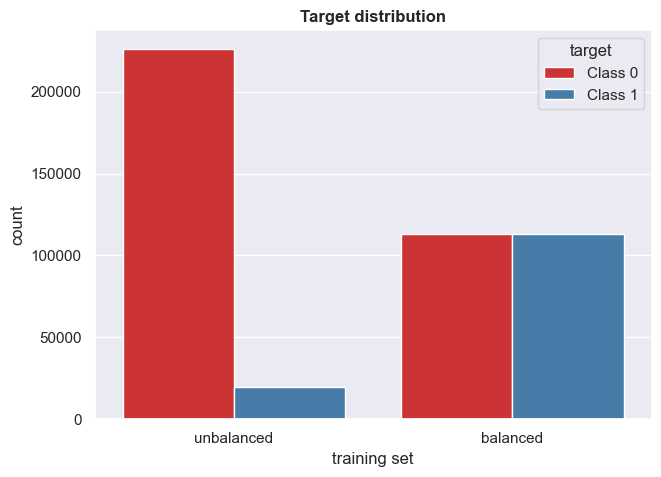

In [70]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration (inside the pipeline).

#### Metric functions

In [71]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def business_loss_func(y_true, y_pred): # 0 --> best # 1 --> worst
    #beta=10
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    #precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    #recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    #score = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    #cost = (fn + 10 * fp) / (len(y_true))
    #score = 1 - cost

    tn_rate, tp_rate, fp_rate, fn_rate = 1, 1, -1, -10

    total_default = tp + fn
    total_not_default = tn + fp

    total_gain = tn*tn_rate + tp*tp_rate + fp*fp_rate + fn*fn_rate
    min_gain = total_not_default*tn_rate + total_default*fn_rate
    max_gain = total_not_default*tn_rate + total_default*tp_rate

    score = (total_gain - min_gain) / (max_gain - min_gain)

    return score

"""def business_scorer(y_true, y_pred): 
    return business_loss_func(y_true, y_pred)"""

business_scorer = make_scorer(business_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func, greater_is_better=True)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func, greater_is_better=False)

#### Classification

In [72]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [126]:
def train_model(name, model, X=x_train, y=y_train, cv=5, fast_train=None, log=True):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train 
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE, stratify=y)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Perform cross-validation with the best model (with or without hyperparameter opt)
    t0 = time.time() 
    scores = cross_validate(pipeline, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)
    print(scores)

    # Get train / validation metrics
    for score in scoring.keys():
        results_cv[score] = scores[f'test_{score}'].mean()
    results_cv['fit_time'] = scores['fit_time'].mean()
    results_cv['execution_time'] = time.time() - t0

    # Fit / train with training set
    t0 = time.time()
    pipeline.fit(x_train, y_train)
    results_test['fit_time'] = time.time() - t0

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1]

    # Calculate test metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)
    
    # Plot confusion matrix and roc curve
    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)

    if log == True: 
    # Save logs
        with mlflow.start_run(run_name=name):
            # Set parameters
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)

            # Set train / validation metrics
            mlflow.log_metric('validation_business_score', results_cv['business_score'])
            mlflow.log_metric('validation_auc', results_cv['roc_auc'])
            mlflow.log_metric('validation_f1', results_test['f1'])
            mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
            mlflow.log_metric('validation_precision', results_cv['precision'])
            mlflow.log_metric('validation_recall', results_cv['recall'])
            mlflow.log_metric('validation_specificity', results_cv['specificity'])
            mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
            mlflow.log_metric('validation_fit_time', results_cv['fit_time'])
            mlflow.log_metric('validation_execution_time', results_cv['execution_time'])

            # Set test metrics
            mlflow.log_metric('test_business_score', results_test['business_score'])
            mlflow.log_metric('test_auc', results_test['roc_auc'])
            mlflow.log_metric('test_f1', results_test['f1'])
            mlflow.log_metric('test_accuracy', results_test['accuracy'])
            mlflow.log_metric('test_precision', results_test['precision'])
            mlflow.log_metric('test_recall', results_test['recall'])
            mlflow.log_metric('test_specificity', results_test['specificity'])
            mlflow.log_metric('test_false_positive_rate', results_test['fpr'])
            mlflow.log_metric('test_fit_time', results_test['fit_time'])
            
            # Save model to artifacts
            mlflow.sklearn.log_model(model, name)

    return pipeline, results_cv, results_test

In [74]:
def search_hyperparameters(name, model, X=x_train, y=y_train, cv=5, param_grid=None, fast_train=None, random=True, n_iter=10):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train / hyperparameter optmization
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    # Perform hyperparameter tuning using RandomizedSearchCV or GridSearchCV
    t0 = time.time()
    if random == True:
        grid_searcher = RandomizedSearchCV(pipeline, param_grid, cv=strat_kf, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, refit='business_score', verbose=3, n_iter=n_iter)
    else:  
        grid_searcher= GridSearchCV(pipeline, param_grid,  cv=strat_kf, scoring=scoring, n_jobs=-1, refit='business_score', verbose=3)

    grid_searcher.fit(x_train, y_train) 
    best_model = grid_searcher.best_estimator_
    best_params = grid_searcher.best_params_
    best_index = grid_searcher.cv_results_['params'].index(grid_searcher.best_params_)
    for score in scoring.keys():
        results_cv[score] = grid_searcher.cv_results_['mean_test_' + score][best_index]
    results_cv['search_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)[:, 1]

    # Calculate validation metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)

    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)
    
    # Get constant hyperparameters
    model_params = list(model.get_params().keys())
    variable_params = list(param_grid.keys())
    variable_params = [param[len('classifier__'):] for param in variable_params]
    constant_params = [param for param in model_params if param not in variable_params]

    # Start MLFlow run 
    with mlflow.start_run(run_name=name) as parent_run:
        # Loop through each iteration of RandomizedSearchCV
        for i, params in enumerate(grid_searcher.cv_results_['params']):
            with mlflow.start_run(run_name='RandomizedSearchCV_'+str(i), nested=True) as child_run:
                # Set constant parameters
                for param, value in model.get_params().items():
                    if param in constant_params: 
                        mlflow.log_param(param, value)
                # Set variable parameters
                params = {key[len('classifier__'):]: value for key, value in params.items()}
                mlflow.log_params(params)

                # Set validation metrics
                mlflow.log_metric('validation_business_score', grid_searcher.cv_results_['mean_test_business_score'][i])
                mlflow.log_metric('validation_auc', grid_searcher.cv_results_['mean_test_roc_auc'][i])
                mlflow.log_metric('validation_f1', grid_searcher.cv_results_['mean_test_f1'][i])
                mlflow.log_metric('validation_accuracy', grid_searcher.cv_results_['mean_test_accuracy'][i])
                mlflow.log_metric('validation_precision', grid_searcher.cv_results_['mean_test_precision'][i])
                mlflow.log_metric('validation_recall', grid_searcher.cv_results_['mean_test_recall'][i])
                mlflow.log_metric('validation_specificity', grid_searcher.cv_results_['mean_test_specificity'][i])
                mlflow.log_metric('validation_false_positive_rate', grid_searcher.cv_results_['mean_test_fpr'][i])
                mlflow.log_metric('validation_fit_time', grid_searcher.cv_results_['mean_fit_time'][i])
                mlflow.log_metric('validation_score_time', grid_searcher.cv_results_['mean_score_time'][i])

        # Save information for best model
        # Set constant parameters
        for param, value in model.get_params().items():
            if param in constant_params: 
                mlflow.log_param(param, value)
                
        # Set variable parameters
        best_params = {key[len('classifier__'):]: value for key, value in best_params.items()}
        mlflow.log_params(best_params)

        # Set train / validation metrics
        mlflow.log_metric('validation_business_score', results_cv['business_score'])
        mlflow.log_metric('validation_auc', results_cv['roc_auc'])
        mlflow.log_metric('validation_f1', results_test['f1'])
        mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
        mlflow.log_metric('validation_precision', results_cv['precision'])
        mlflow.log_metric('validation_recall', results_cv['recall'])
        mlflow.log_metric('validation_specificity', results_cv['specificity'])
        mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
        mlflow.log_metric('search_time', results_cv['search_time'])

        # Set test metrics
        mlflow.log_metric('test_business_score', results_test['business_score'])
        mlflow.log_metric('test_auc', results_test['roc_auc'])
        mlflow.log_metric('test_f1', results_test['f1'])
        mlflow.log_metric('test_accuracy', results_test['accuracy'])
        mlflow.log_metric('test_precision', results_test['precision'])
        mlflow.log_metric('test_recall', results_test['recall'])
        mlflow.log_metric('test_specificity', results_test['specificity'])
        mlflow.log_metric('test_false_positive_rate', results_test['fpr'])

        # Save model to artifacts
        mlflow.sklearn.log_model(best_model, name)

    return best_model, results_cv, results_test


In [75]:
def plot_metrics(results_cv, results_test, metrics): 
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    # Pastel colors
    pastel_colors = ['#FF6666', '#FFCC99', '#99FF99', '#66B2FF', '#C2C2F0', '#999966', '#FF69B4', '#B19CD9']

    # Models to remove x-axis and y-axis labels
    no_x_labels = []#['DummyClassifier', 'LogisticRegression', 'RandomForest']
    no_y_labels = []#['LogisticRegression', 'RandomForest', 'LightGBM', 'CatBoost']

    # Iterate over models and plot metrics
    for i, model in enumerate(results_cv.keys()):
        metrics_dict = results_cv[model]
        test_metrics_dict = results_test[model]
        ax = axs[i // 3, i % 3]

        x = np.arange(len(metrics))
        width = 0.4

        # Train bars
        train_metrics = [metrics_dict[metric] for metric in metrics]
        ax.bar(x - width/2, train_metrics, width, label='Train', color=pastel_colors, alpha=0.7)

        # Test bars
        test_metrics = [test_metrics_dict[metric] for metric in metrics]
        ax.bar(x + width/2, test_metrics, width, label='Test', color='gray', alpha=0.7)

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45)
        ax.set_ylim(0, 1)

        if model in no_x_labels:
            ax.set_xticklabels([])

        if model in no_y_labels:
            ax.set_yticklabels([])

    # Adjust subplot layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Add a legend
    axs[1, 2].legend(loc='upper right')

    # Show the plots
    plt.show()

#### Modelling

For the sake of computation, we will use 20% of the data

##### DummyClassifier (= baseline 0)

CPU times: total: 0 ns
Wall time: 0 ns
{'fit_time': array([8.3276701 , 7.86270404, 8.34086871, 8.3276701 , 8.27567267]), 'score_time': array([0.17951608, 0.22216582, 0.17711091, 0.18586946, 0.26235271]), 'test_accuracy': array([0.49390244, 0.49237805, 0.49034553, 0.49390244, 0.48869411]), 'test_precision': array([0.07916562, 0.0776577 , 0.07564715, 0.07916562, 0.07413923]), 'test_recall': array([0.49606299, 0.48661417, 0.47401575, 0.49606299, 0.46383648]), 'test_f1': array([0.13654096, 0.13394018, 0.13047248, 0.13654096, 0.12784399]), 'test_roc_auc': array([0.49488793, 0.48974898, 0.48289705, 0.49488793, 0.47735771]), 'test_specificity': array([0.49371286, 0.49288379, 0.49177836, 0.49371286, 0.49087894]), 'test_fpr': array([-0.50628714, -0.50711621, -0.50822164, -0.50628714, -0.50912106]), 'test_business_score': array([-0.55304223, -0.56420902, -0.57909807, -0.55304223, -0.58933676])}


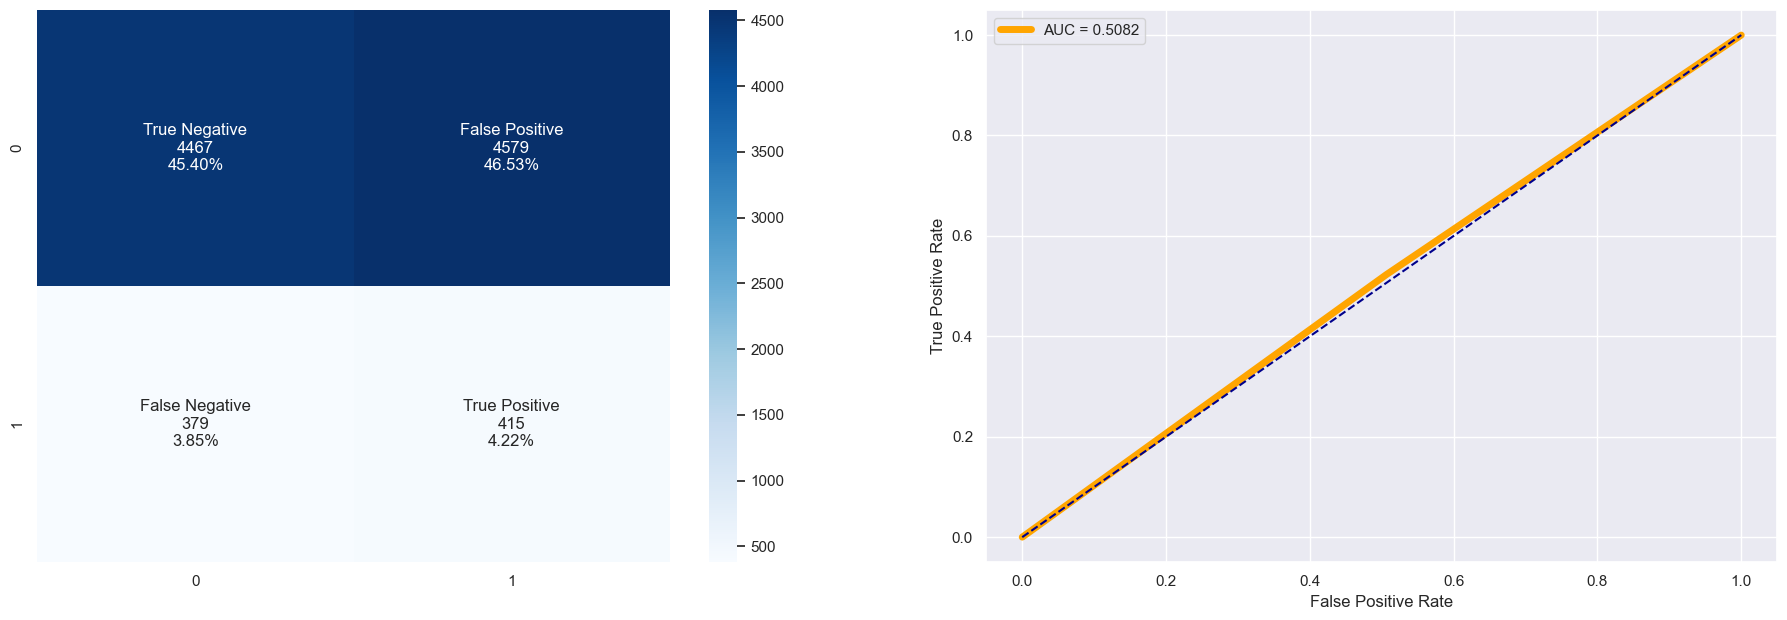

In [76]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_test = train_model(dc_name, dc, cv=5, fast_train=0.2)

##### Logistical regression (= baseline 1)

CPU times: total: 0 ns
Wall time: 0 ns
{'fit_time': array([22.37913203, 20.49684286, 22.37816525, 23.69547081, 26.24206114]), 'score_time': array([0.22145319, 0.20699549, 0.18422794, 0.36191487, 0.29144835]), 'test_accuracy': array([0.86305894, 0.88287602, 0.85721545, 0.87944614, 0.88262195]), 'test_precision': array([0.13509061, 0.14914425, 0.11374408, 0.16163793, 0.15550239]), 'test_recall': array([0.12913386, 0.09606299, 0.11338583, 0.11811024, 0.10220126]), 'test_f1': array([0.13204509, 0.11685824, 0.11356467, 0.13648772, 0.12333966]), 'test_roc_auc': array([0.55406806, 0.5449339 , 0.56972426, 0.57121115, 0.54625849]), 'test_specificity': array([0.92745613, 0.95191378, 0.92248169, 0.94624845, 0.95121614]), 'test_fpr': array([-0.07254387, -0.04808622, -0.07751831, -0.05375155, -0.04878386]), 'test_business_score': array([-0.02118826, -0.0035791 , -0.04724409,  0.0067287 ,  0.00128645])}


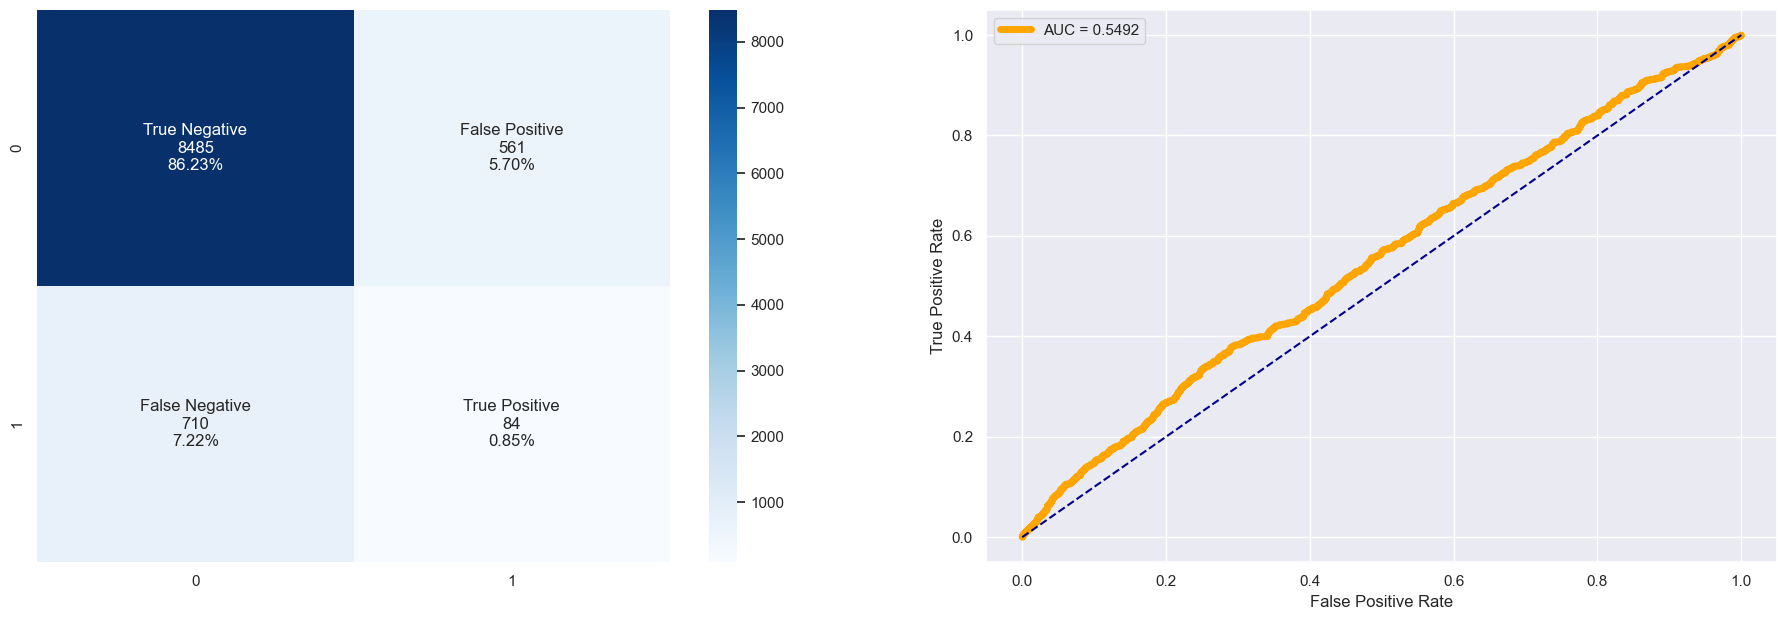

In [77]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_test = train_model(lr_name, lr, cv=5, fast_train=0.2)

##### RandomForest

CPU times: total: 0 ns
Wall time: 0 ns
{'fit_time': array([54.19272208, 53.52365065, 54.17682838, 52.58191133, 53.67981887]), 'score_time': array([1.43739462, 1.58721757, 1.38235044, 2.30980802, 1.71371722]), 'test_accuracy': array([0.91514228, 0.91628557, 0.91653963, 0.9171748 , 0.91590447]), 'test_precision': array([0.2295082 , 0.26      , 0.28      , 0.36507937, 0.27586207]), 'test_recall': array([0.02204724, 0.02047244, 0.02204724, 0.03622047, 0.02515723]), 'test_f1': array([0.04022989, 0.0379562 , 0.04087591, 0.06590258, 0.04610951]), 'test_roc_auc': array([0.68295069, 0.70873247, 0.71891483, 0.71826604, 0.69714321]), 'test_specificity': array([0.9935056 , 0.99488738, 0.99502556, 0.99447285, 0.99419569]), 'test_fpr': array([-0.0064944 , -0.00511262, -0.00497444, -0.00552715, -0.00580431]), 'test_business_score': array([0.00858984, 0.00987831, 0.01173944, 0.02476736, 0.01315037])}


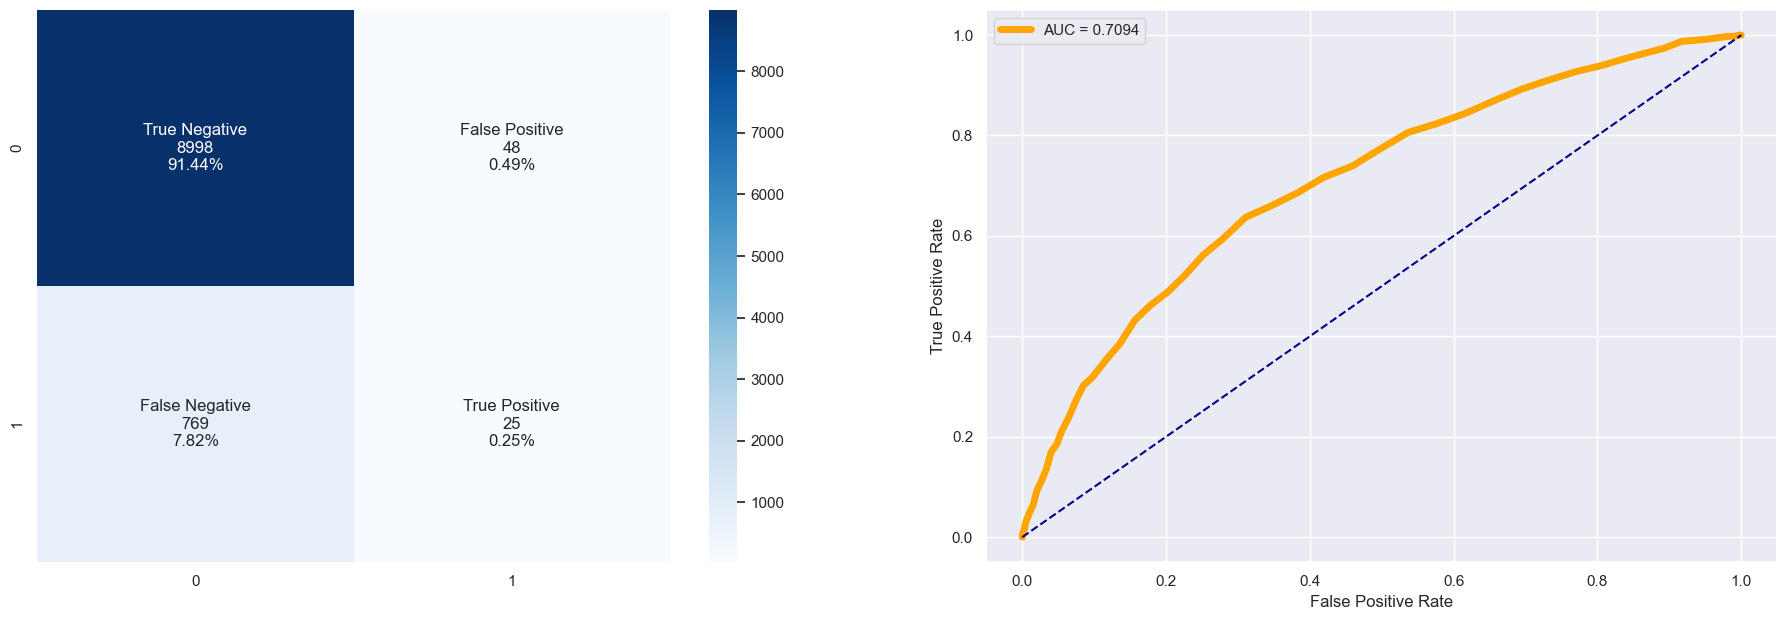

In [78]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_test = train_model(rf_name, rf, cv=5, fast_train=0.2)

##### XGBoost

CPU times: total: 0 ns
Wall time: 435 µs
{'fit_time': array([64.14501214, 66.016114  , 63.9633522 , 66.07386613, 66.07386613]), 'score_time': array([1.25487304, 1.29706526, 1.47848749, 1.22395492, 1.12864804]), 'test_accuracy': array([0.90269309, 0.90193089, 0.90447154, 0.89875508, 0.90027947]), 'test_precision': array([0.29846154, 0.29552239, 0.32432432, 0.27747253, 0.26045016]), 'test_recall': array([0.15275591, 0.15590551, 0.17007874, 0.15905512, 0.12735849]), 'test_f1': array([0.20208333, 0.20412371, 0.2231405 , 0.2022022 , 0.17106653]), 'test_roc_auc': array([0.72827193, 0.72838835, 0.75938827, 0.72937605, 0.70921967]), 'test_specificity': array([0.96849523, 0.9673898 , 0.96890977, 0.96365897, 0.96821448]), 'test_fpr': array([-0.03150477, -0.0326102 , -0.03109023, -0.03634103, -0.03178552]), 'test_business_score': array([0.08747316, 0.08833214, 0.10565497, 0.08375089, 0.06160663])}


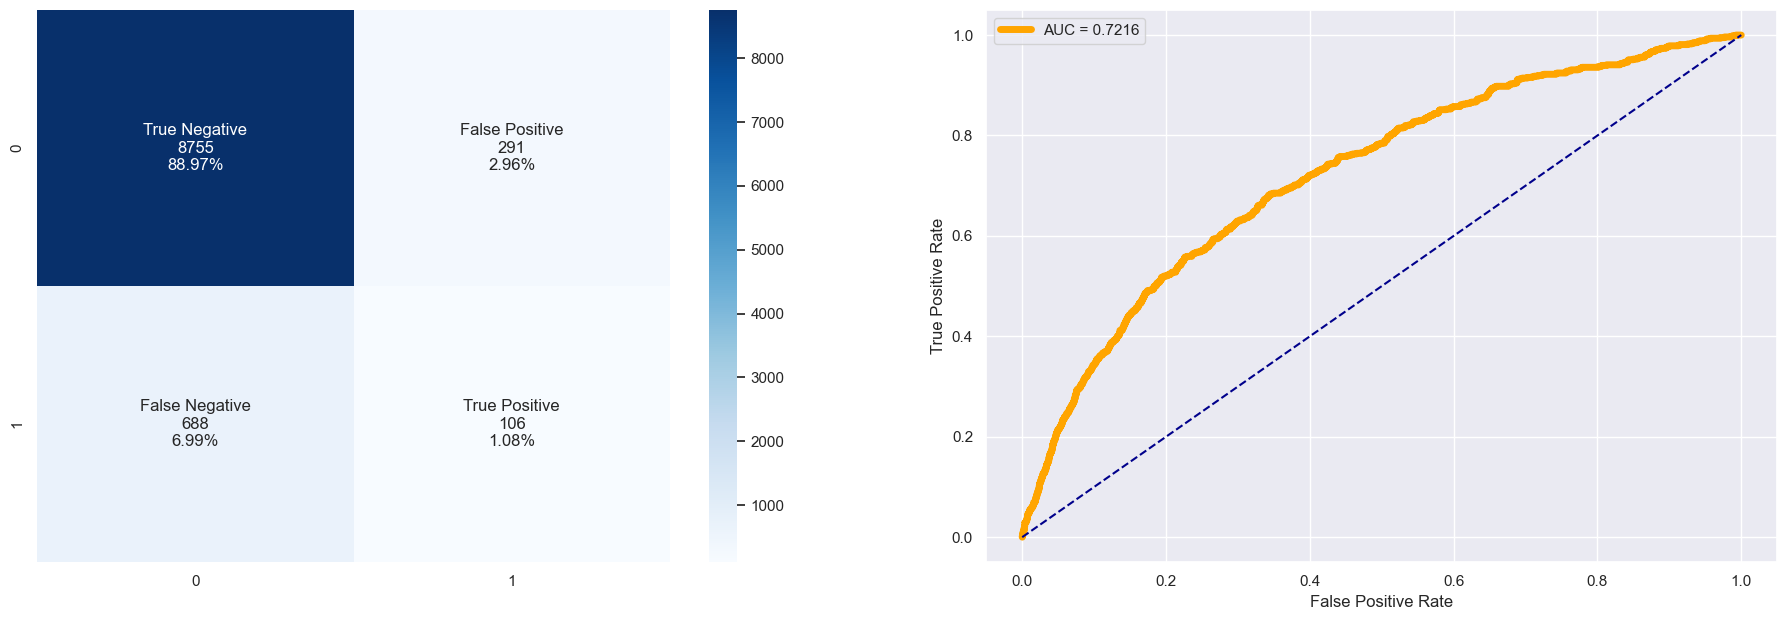

In [79]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_test = train_model(xgbc_name, xgbc, cv=5, fast_train=0.2)

##### LightGBM

CPU times: total: 0 ns
Wall time: 0 ns


{'fit_time': array([49.29561329, 47.92348146, 48.74758911, 70.20214963, 70.6806531 ]), 'score_time': array([0.63417745, 0.65020657, 0.57506132, 0.58951092, 0.53656769]), 'test_accuracy': array([0.91056911, 0.91247459, 0.91183943, 0.91399898, 0.91260163]), 'test_precision': array([0.34246575, 0.36764706, 0.36150235, 0.40186916, 0.38288288]), 'test_recall': array([0.11811024, 0.11811024, 0.12125984, 0.13543307, 0.1336478 ]), 'test_f1': array([0.17564403, 0.17878427, 0.18160377, 0.20259128, 0.1981352 ]), 'test_roc_auc': array([0.75158302, 0.75641035, 0.78326426, 0.76465952, 0.73274808]), 'test_specificity': array([0.98010225, 0.98217493, 0.98120768, 0.98231311, 0.98106689]), 'test_fpr': array([-0.01989775, -0.01782507, -0.01879232, -0.01768689, -0.01893311]), 'test_business_score': array([0.07687903, 0.08117394, 0.08231926, 0.09878311, 0.09448256])}
[LightGBM] [Info] Number of positive: 18092, number of negative: 18092
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bi

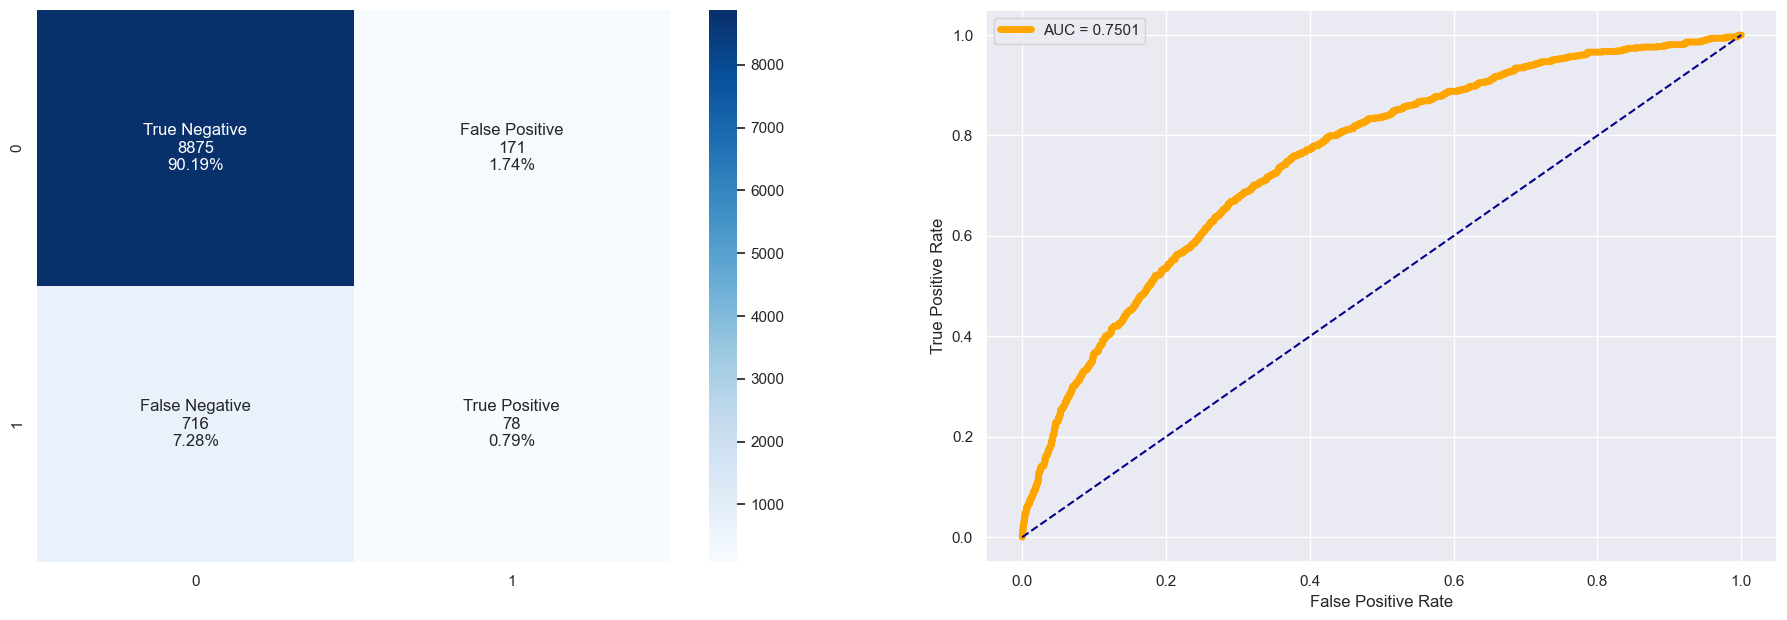

In [80]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='gpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_test = train_model(lgbmc_name, lgbmc, cv=5, fast_train=0.2)

##### CatBoost

CPU times: total: 0 ns
Wall time: 0 ns


{'fit_time': array([529.36795211, 525.71535516, 529.5036211 , 527.28670526,
       527.58318377]), 'score_time': array([0.25252223, 0.75751352, 0.2638042 , 0.72415781, 0.5536437 ]), 'test_accuracy': array([0.9117124 , 0.91196646, 0.91222053, 0.91514228, 0.91323679]), 'test_precision': array([0.35      , 0.36818182, 0.36792453, 0.42180095, 0.38862559]), 'test_recall': array([0.11023622, 0.12755906, 0.12283465, 0.14015748, 0.12893082]), 'test_f1': array([0.16766467, 0.18947368, 0.18417946, 0.21040189, 0.19362456]), 'test_roc_auc': array([0.75320939, 0.757867  , 0.78113152, 0.76645193, 0.74568262]), 'test_specificity': array([0.98203676, 0.98079315, 0.98148404, 0.98314219, 0.98217247]), 'test_fpr': array([-0.01796324, -0.01920685, -0.01851596, -0.01685781, -0.01782753]), 'test_business_score': array([0.0730136 , 0.08775948, 0.08446671, 0.10522548, 0.0920526 ])}
Learning rate set to 0.047689
0:	learn: 0.6374017	total: 287ms	remaining: 4m 46s
1:	learn: 0.5929552	total: 399ms	remaining: 3m 1

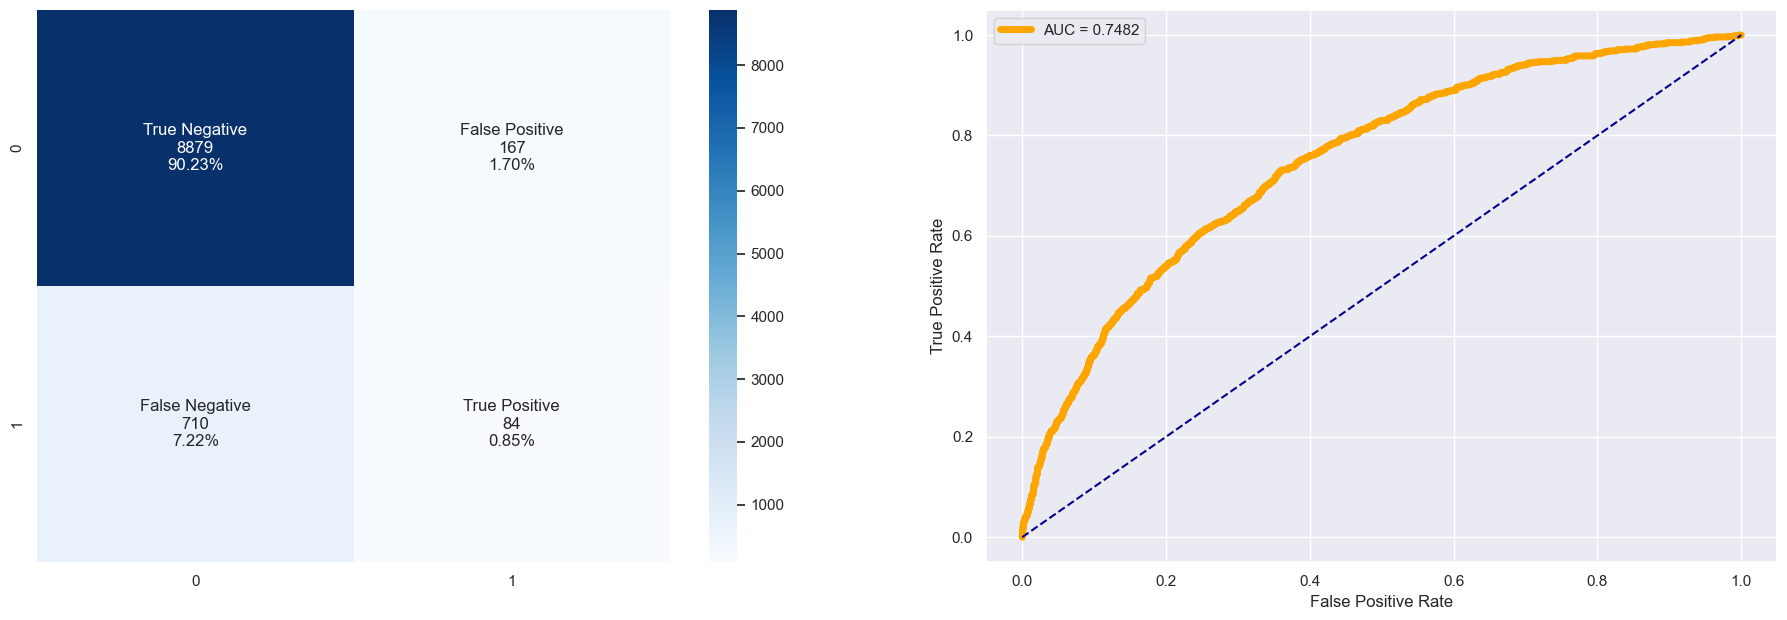

In [81]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_test = train_model(cbc_name, cbc, cv=5, fast_train=0.2)

##### Comparison

In [82]:
results_cv = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lr_results_cv, 
    'RandomForest': rf_results_cv,
    'XGBoost': xgbc_results_cv,
    'LightGBM': lgbmc_results_cv,
    'CatBoost': cbc_results_cv
}

pd.DataFrame.from_dict(results_cv)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
accuracy,0.491845,0.873044,0.916209,0.901626,0.912297,0.912856
precision,0.077155,0.143024,0.282090,0.291246,0.371273,0.379307
recall,0.483318,0.111779,0.025189,0.153031,0.125312,0.125944
f1,0.133068,0.124459,0.046215,0.200523,0.187352,0.189069
roc_auc,0.487956,0.557239,0.705201,0.730929,0.757733,0.760868
specificity,0.492593,0.939863,0.994417,0.967334,0.981373,0.981926
fpr,-0.507407,-0.060137,-0.005583,-0.032666,-0.018627,-0.018074
business_score,-0.567746,-0.012799,0.013625,0.085364,0.086728,0.088504
fit_time,8.226917,23.038334,53.630986,65.254442,57.369897,527.891363
execution_time,34.811446,28.403873,56.515486,69.329397,77.048723,532.486413


In [83]:
results_test = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lr_results_test, 
    'RandomForest': rf_results_test,
    'XGBoost': xgbc_results_test,
    'LightGBM': lgbmc_results_test,
    'CatBoost': cbc_results_test
}

pd.DataFrame.from_dict(results_test)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
fit_time,2.384219,16.452286,21.836092,25.787869,28.130628,109.465369
accuracy,0.496138,0.870833,0.916972,0.900508,0.909858,0.910874
precision,0.083100,0.130233,0.342466,0.267003,0.313253,0.334661
recall,0.522670,0.105793,0.031486,0.133501,0.098237,0.105793
f1,0.143400,0.116748,0.057670,0.178002,0.149569,0.160766
roc_auc,0.508240,0.549234,0.709392,0.721583,0.750064,0.748192
specificity,0.493809,0.937984,0.994694,0.967831,0.981097,0.981539
fpr,0.506191,0.062016,0.005306,0.032169,0.018903,0.018461
business_score,-0.525876,-0.022670,0.020495,0.066865,0.059079,0.067552


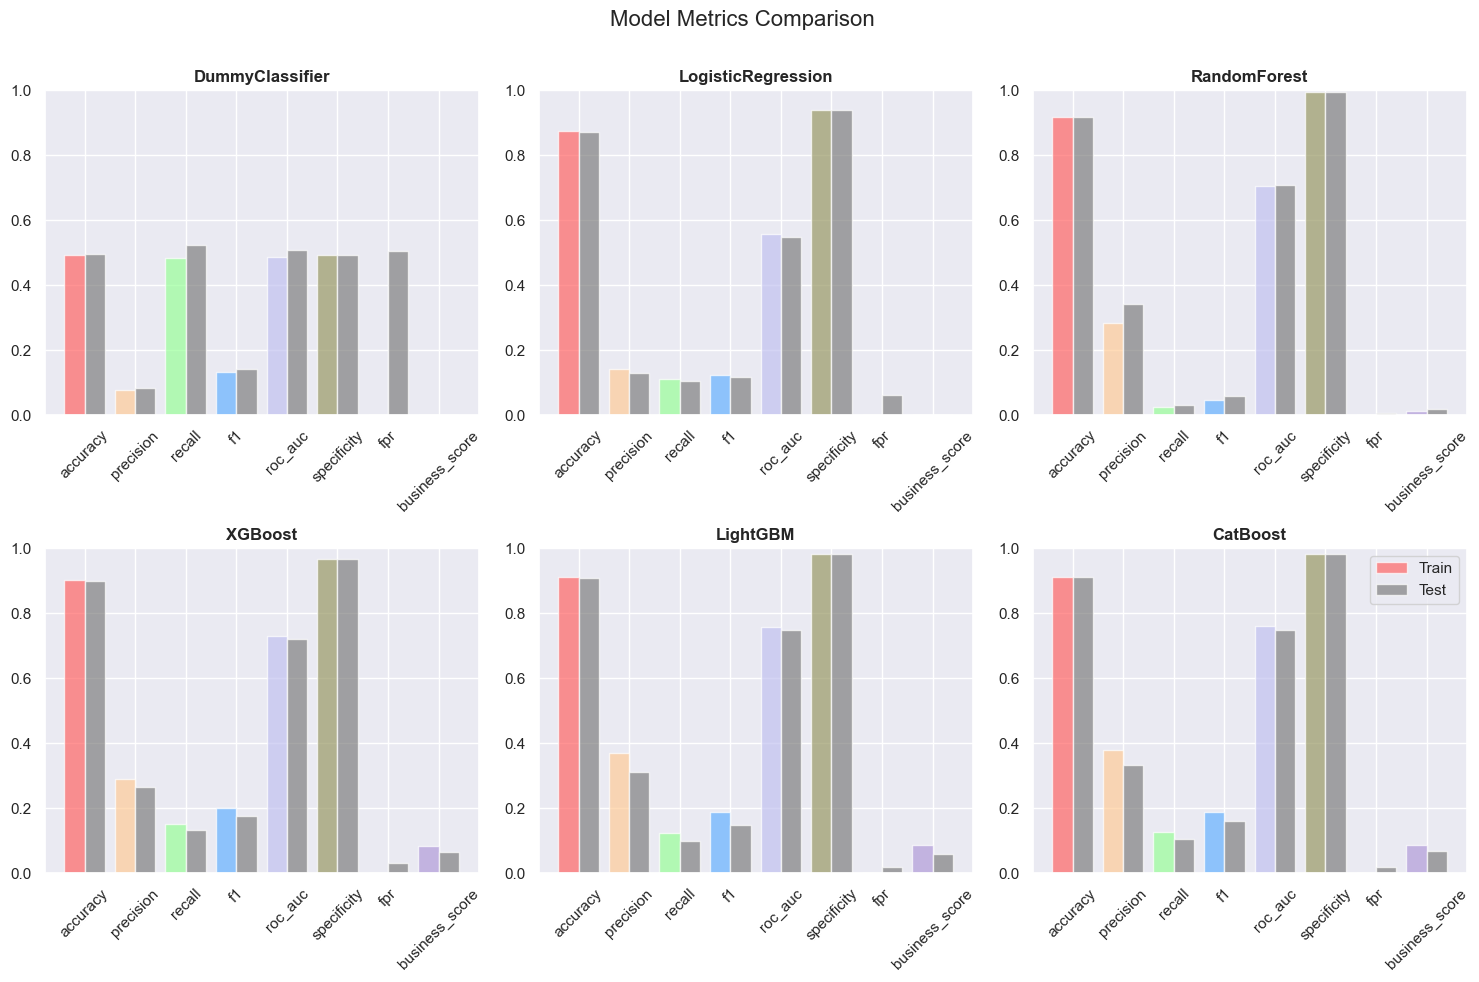

In [84]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv, results_test, metrics)

#### Hyperparameter optimization

For hyperparameter optimization, let's change few things for the sake of computation capacity: 
- Use 20% of total data

##### DummyClassifier (= baseline 0)

Since this one is the baseline 0, it does not need to be optimized.

##### Logistical regression (= baseline 1)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 10 candidates, totalling 50 fits


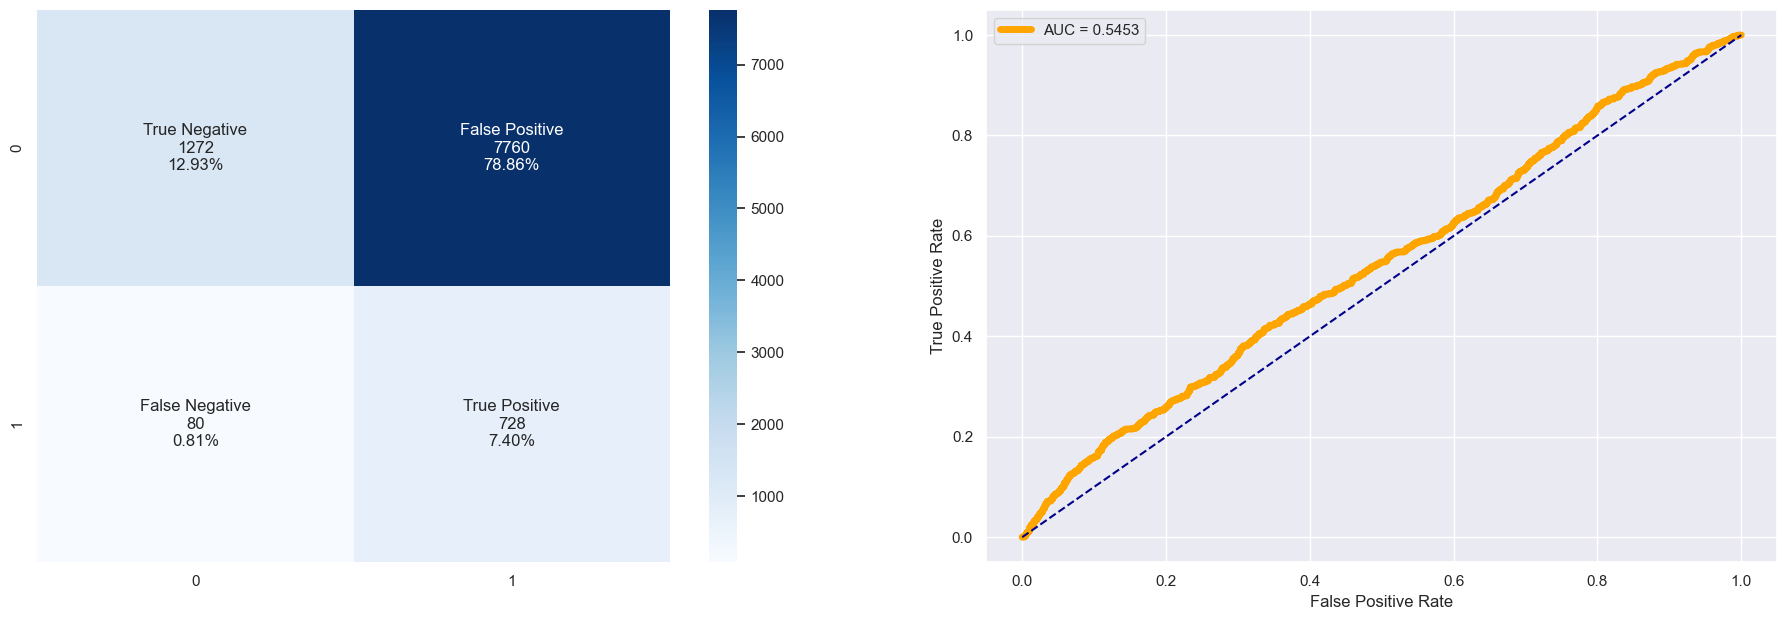

In [85]:
%time
# Create logistic regression model
lrt = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lrt_name = 'LogisticRegression_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2', 'none'],  # Regularization penalty --> only use l2 due to one-hot encode
    'classifier__solver': ['lbfgs', 'saga', 'newton-cholesky'],  # Solver options
    'classifier__max_iter': [100, 500, 1000],  # Maximum iterations
}

# Compute results and get fine-tuned model
lrt_model, lrt_results_cv, lrt_results_test = search_hyperparameters(lrt_name, lrt, param_grid=param_grid, cv=5, fast_train=0.2)

##### RandomForest

CPU times: total: 0 ns
Wall time: 1e+03 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


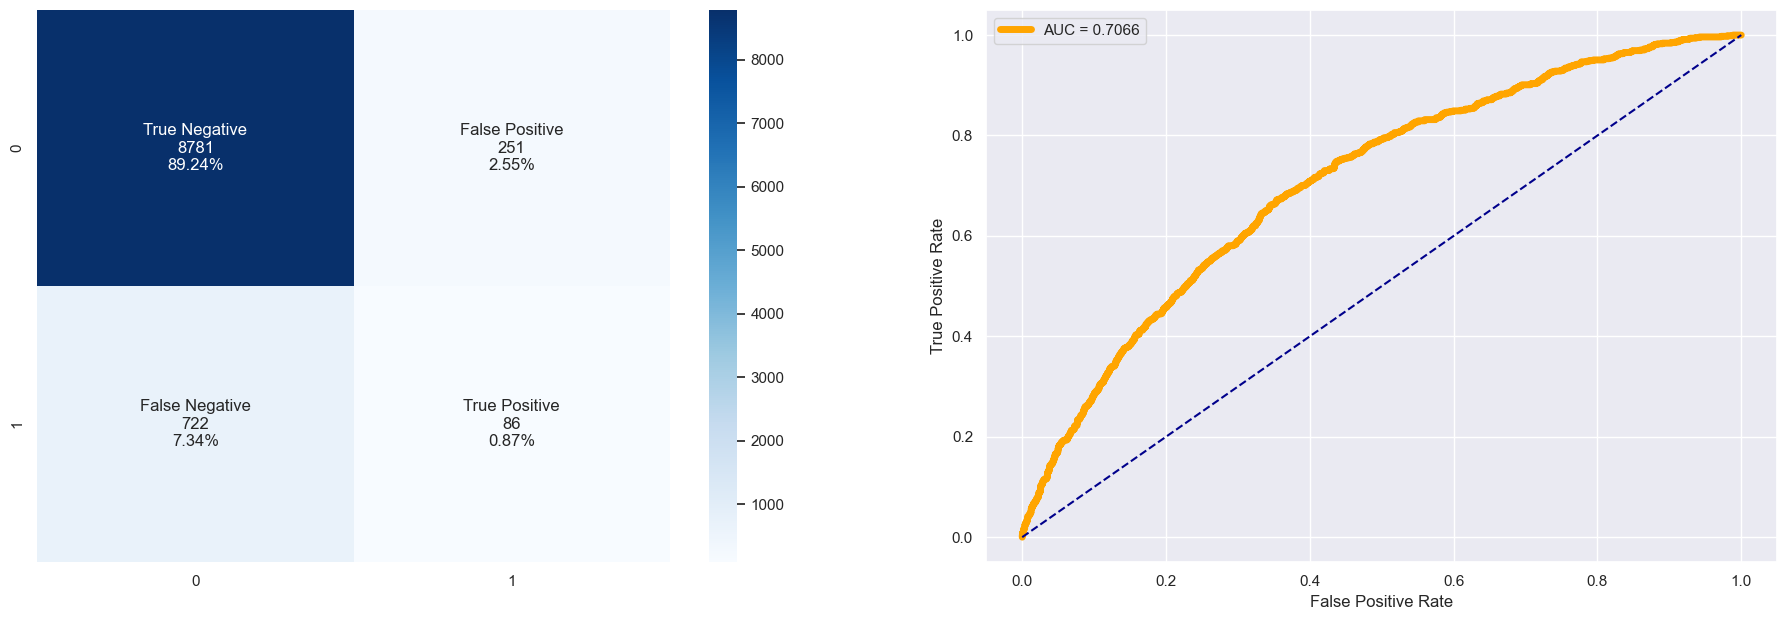

In [86]:
%time
# Create random forest classifier
rft = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rft_name = 'RandomForest_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt'],
}

# Compute results and get fine-tuned model
rft_model, rft_results_cv, rft_results_test = search_hyperparameters(rft_name, rft, param_grid=param_grid, cv=5, fast_train=0.2)

##### XGBoost

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 10 candidates, totalling 50 fits


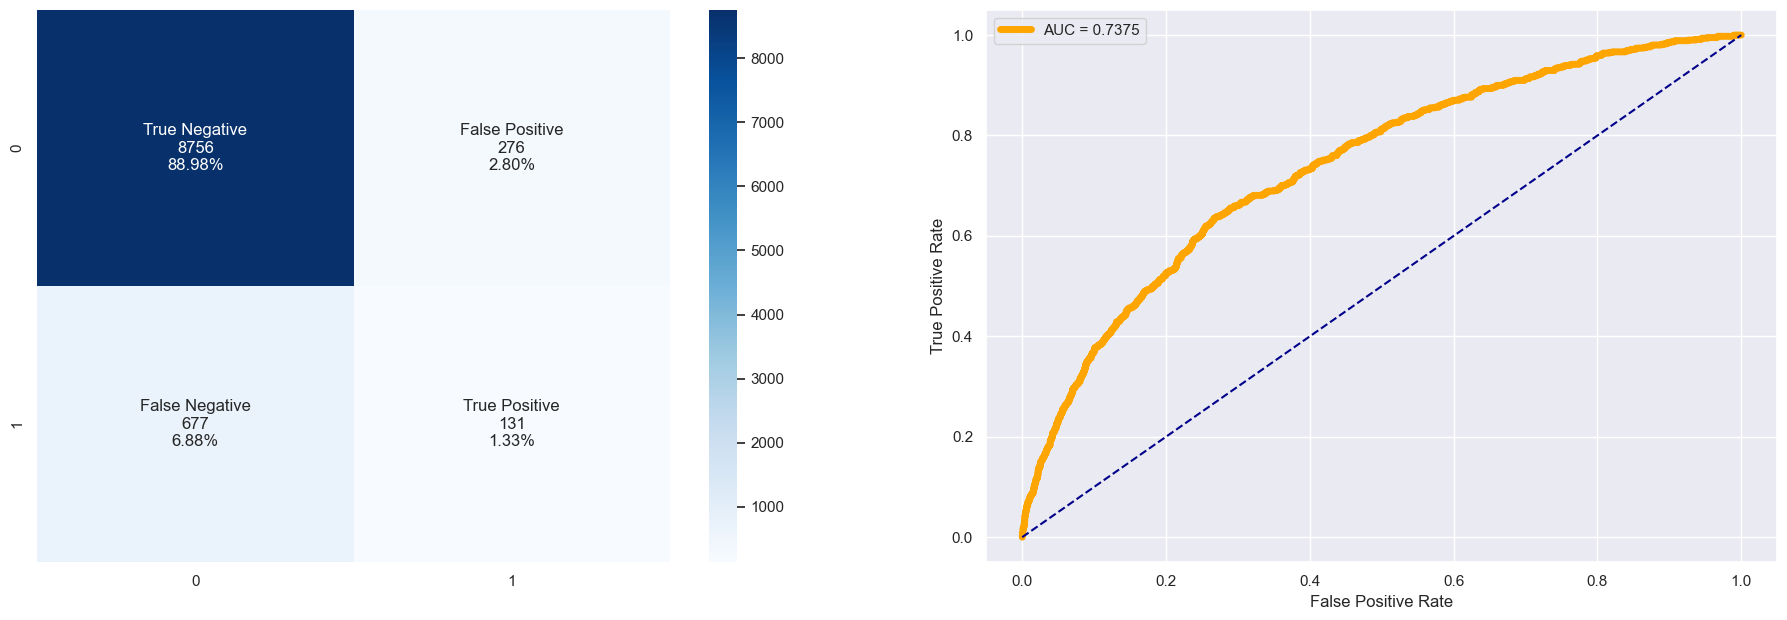

In [87]:
%time
# Create XGBoost classifier
xgbct = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbct_name = 'XGBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
xgbct_model, xgbct_results_cv, xgbct_results_test = search_hyperparameters(xgbct_name, xgbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### LightGBM

CPU times: total: 0 ns
Wall time: 1.2 ms
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 18085, number of negative: 18085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101222
[LightGBM] [Info] Number of data points in the train set: 36170, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

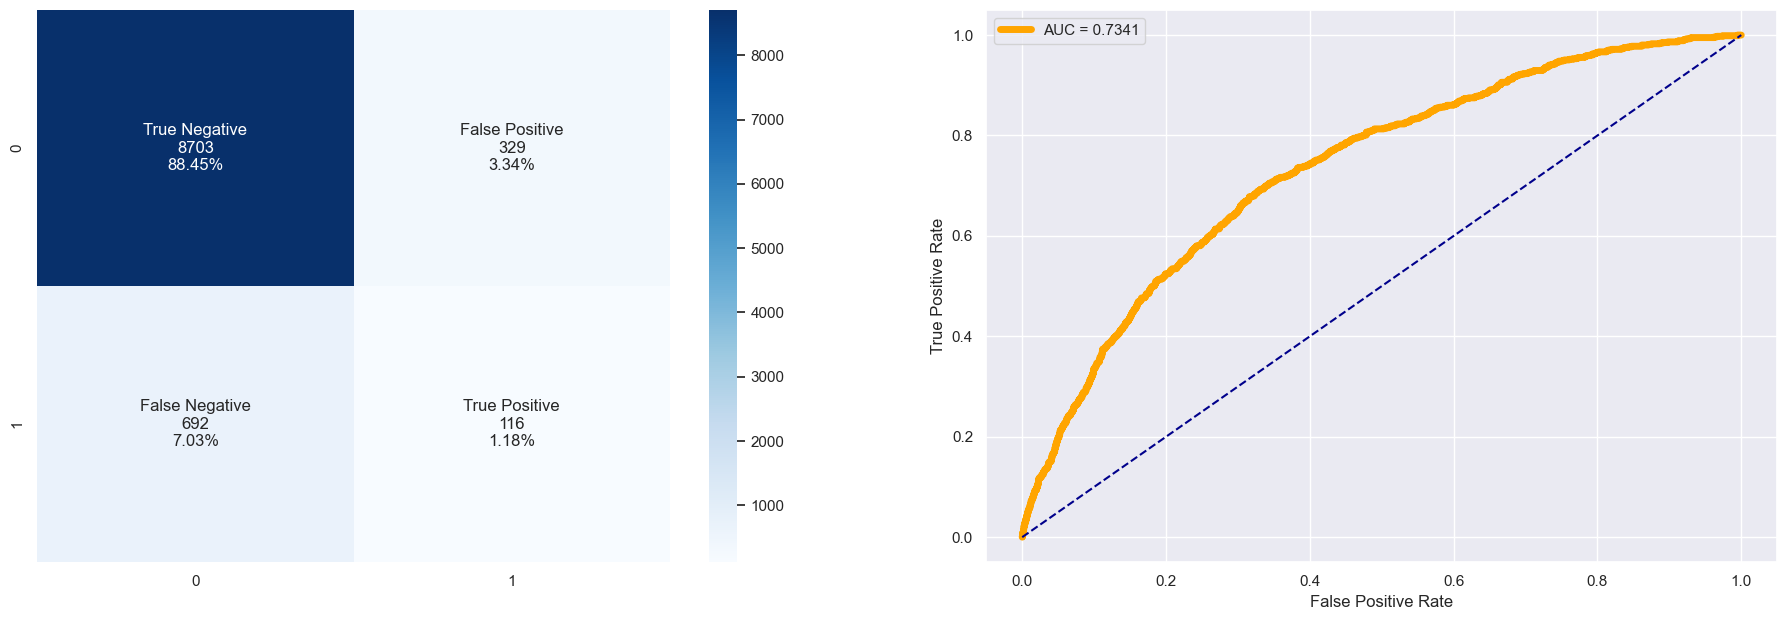

In [90]:
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3 , 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

##### CatBoost

CPU times: total: 0 ns
Wall time: 571 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.5980182	total: 196ms	remaining: 39s
1:	learn: 0.5239792	total: 350ms	remaining: 34.6s
2:	learn: 0.4633881	total: 504ms	remaining: 33.1s
3:	learn: 0.4316843	total: 650ms	remaining: 31.9s
4:	learn: 0.3934895	total: 790ms	remaining: 30.8s
5:	learn: 0.3671790	total: 982ms	remaining: 31.7s
6:	learn: 0.3478512	total: 1.13s	remaining: 31.3s
7:	learn: 0.3391959	total: 1.27s	remaining: 30.5s
8:	learn: 0.3236400	total: 1.41s	remaining: 30s
9:	learn: 0.3140598	total: 1.55s	remaining: 29.4s
10:	learn: 0.3014355	total: 1.7s	remaining: 29.2s
11:	learn: 0.2917877	total: 1.83s	remaining: 28.7s
12:	learn: 0.2854139	total: 1.98s	remaining: 28.5s
13:	learn: 0.2798919	total: 2.13s	remaining: 28.3s
14:	learn: 0.2734741	total: 2.27s	remaining: 28s
15:	learn: 0.2687522	total: 2.41s	remaining: 27.7s
16:	learn: 0.2665335	total: 2.57s	remaining: 27.6s
17:	learn: 0.2643826	total: 2.71s	remaining: 27.

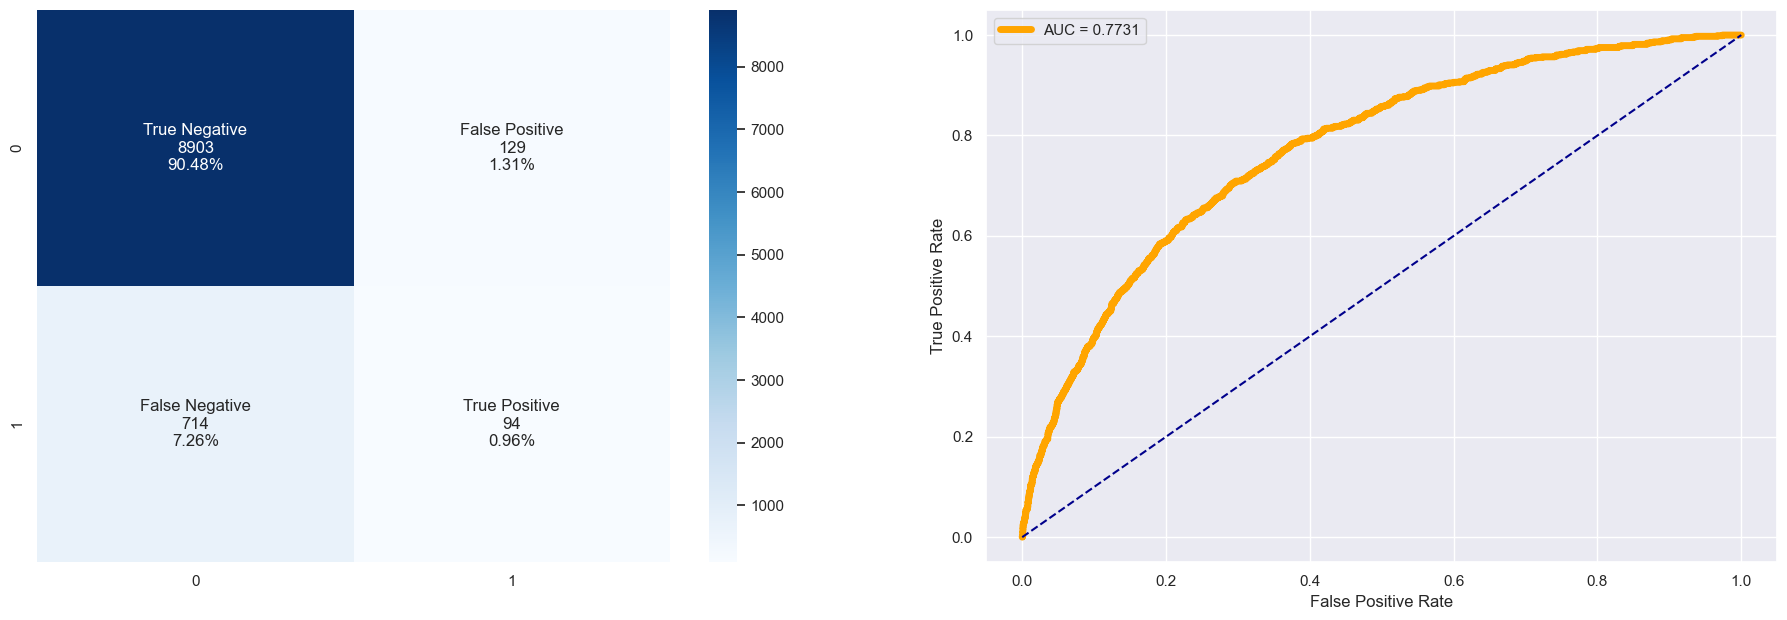

In [91]:
%time
# Create CatBoost classifier
cbct = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbct_name = 'CatBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],  
}

# Compute results and get fine-tuned model
cbct_model, cbct_results_cv, cbct_results_test = search_hyperparameters(cbct_name, cbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### Comparison

In [92]:
results_cv_tuned = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lrt_results_cv, 
    'RandomForest': rft_results_cv,
    'XGBoost': xgbct_results_cv,
    'LightGBM': lgbmct_results_cv,
    'CatBoost': cbct_results_cv
}

pd.DataFrame.from_dict(results_cv_tuned)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
accuracy,0.491845,0.209299,0.902287,0.901245,0.901702,0.913872
precision,0.077155,0.084496,0.253482,0.298058,0.299041,0.391467
recall,0.483318,0.890282,0.104702,0.162382,0.158621,0.112539
f1,0.133068,0.154343,0.147722,0.210029,0.206994,0.174719
roc_auc,0.487956,0.528102,0.699951,0.726925,0.722694,0.752480
specificity,0.492593,0.149240,0.972629,0.966409,0.967238,0.984545
fpr,-0.507407,-0.850760,-0.027371,-0.033591,-0.032762,-0.015455
business_score,-0.567746,-0.863608,0.048276,0.093132,0.091080,0.080678
fit_time,8.226917,NaN,NaN,NaN,NaN,NaN
execution_time,34.811446,NaN,NaN,NaN,NaN,NaN


In [93]:
results_test_tuned = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lrt_results_test, 
    'RandomForest': rft_results_test,
    'XGBoost': xgbct_results_test,
    'LightGBM': lgbmct_results_test,
    'CatBoost': cbct_results_test
}

pd.DataFrame.from_dict(results_test_tuned)

,DummyClassifier,LogisticRegression,RandomForest,XGBoost,LightGBM,CatBoost
fit_time,2.384219,NaN,NaN,NaN,NaN,NaN
accuracy,0.496138,0.203252,0.901118,0.903150,0.896240,0.914329
precision,0.083100,0.085768,0.255193,0.321867,0.260674,0.421525
recall,0.522670,0.900990,0.106436,0.162129,0.143564,0.116337
f1,0.143400,0.156627,0.150218,0.215638,0.185156,0.182347
roc_auc,0.508240,0.545293,0.706554,0.737526,0.734068,0.773057
specificity,0.493809,0.140833,0.972210,0.969442,0.963574,0.985717
fpr,0.506191,0.859167,0.027790,0.030558,0.036426,0.014283
business_score,-0.525876,-0.845185,0.049955,0.100023,0.069532,0.087309


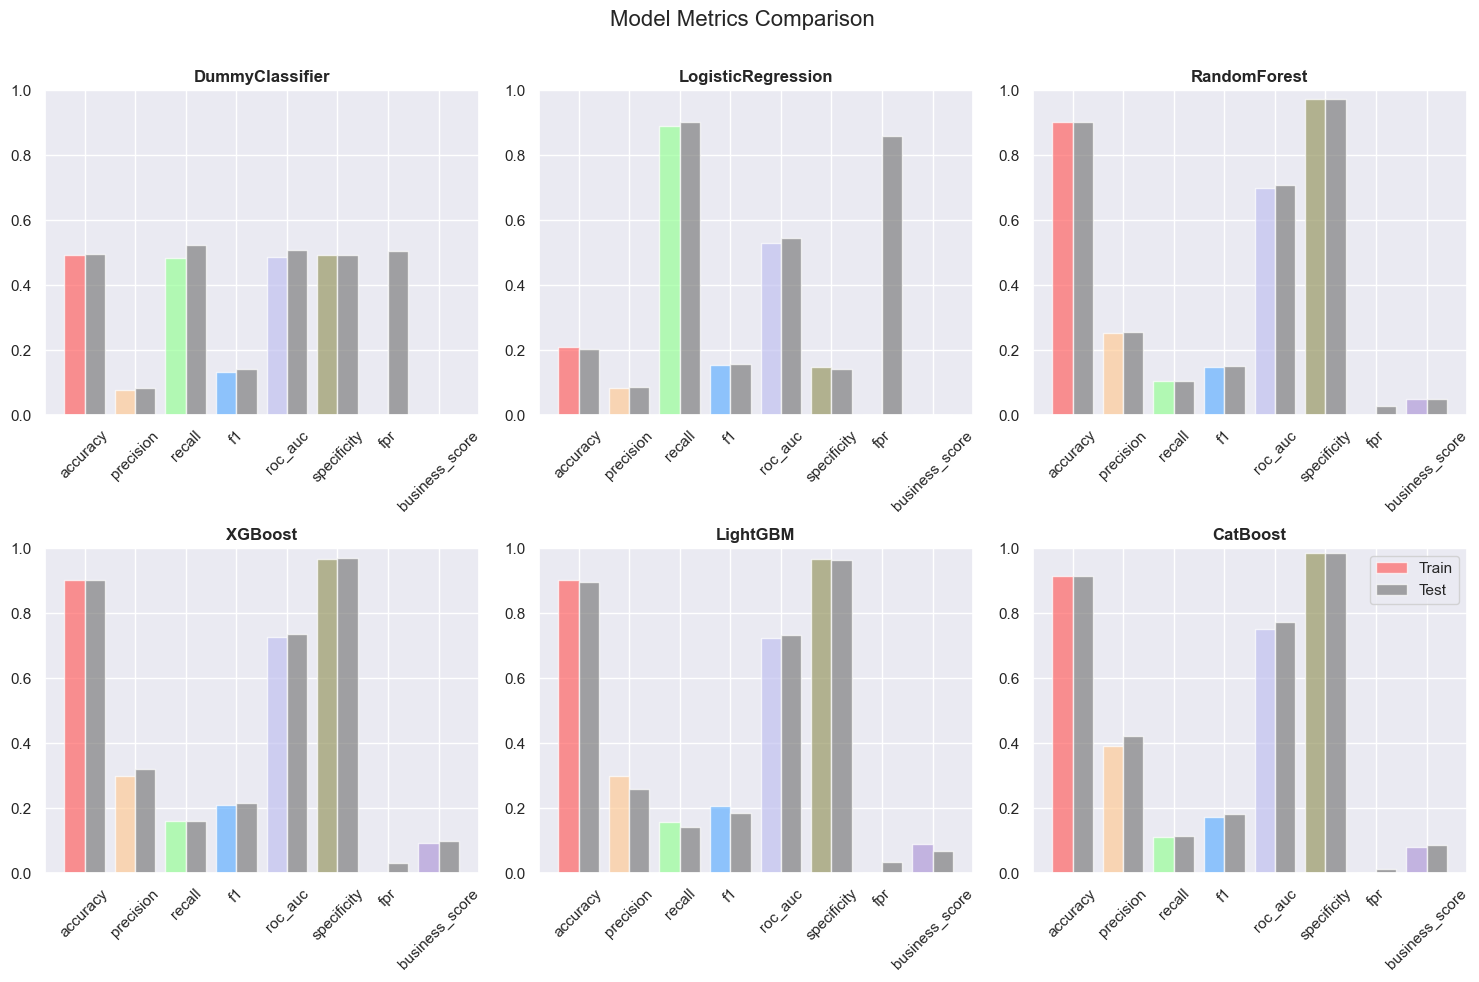

In [94]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv_tuned, results_test_tuned, metrics)

In [95]:
# Comparison between model before and after fine tuning

def plot_metrics_dual_per_model(model_name, train_results, test_results, train_results_ft, test_results_ft):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
    
    # Define colors
    colors = {'Val': 'darkblue', 'Test': 'darkorange', 'Val-FT': 'darkblue', 'Test-FT': 'darkorange'}

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Add a super title with the model's name
    fig.suptitle(model_name, fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 4, i % 4]
        data = [
            train_results.get(metric, 0),
            test_results.get(metric, 0),
            train_results_ft.get(metric, 0),
            test_results_ft.get(metric, 0),
        ]
        x_labels = ['Val', 'Test', 'Val-FT', 'Test-FT']

        ax.bar(x_labels, data, color=[colors[label] for label in x_labels])
        ax.set_ylabel(metric)
        ax.set_title(metric)

        # Rotate x-axis labels
        ax.set_xticklabels(x_labels, rotation=45)

        # Set y-axis limits to vary from 0 to 1
        ax.set_ylim(0, 1)

    plt.tight_layout()  # Set the layout tight
    plt.show()

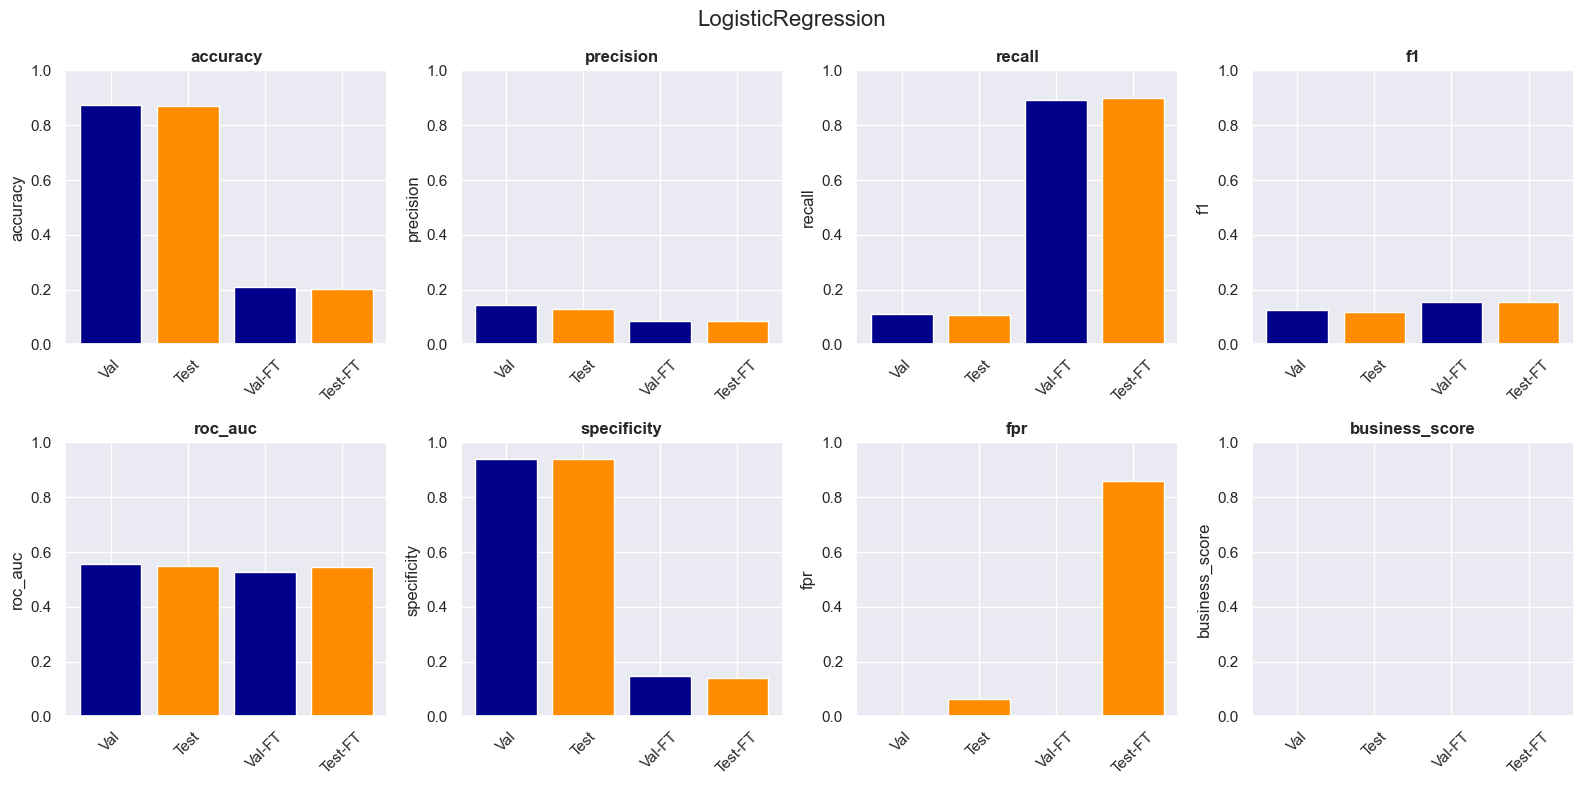

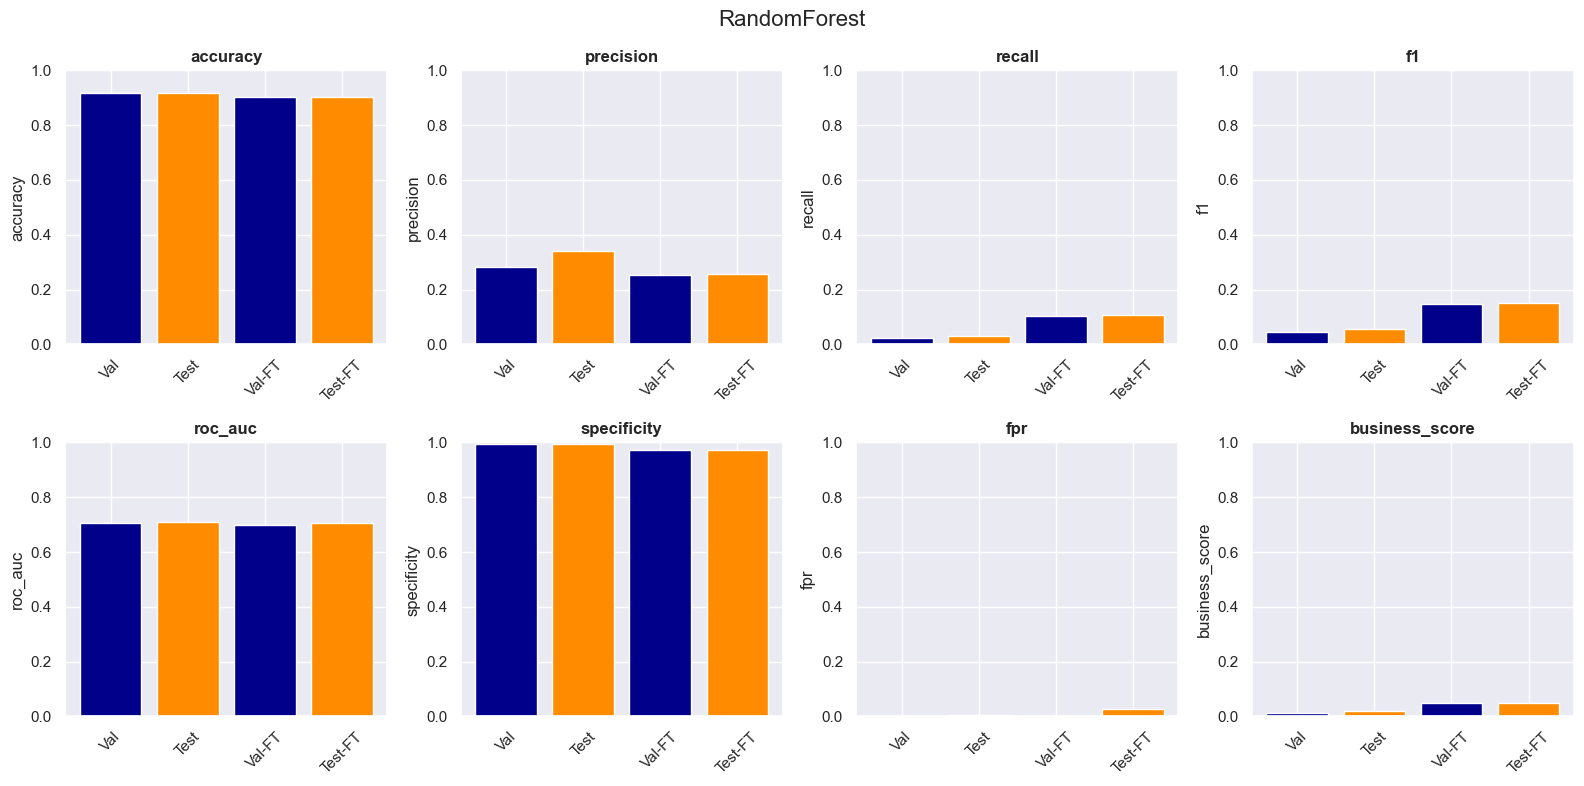

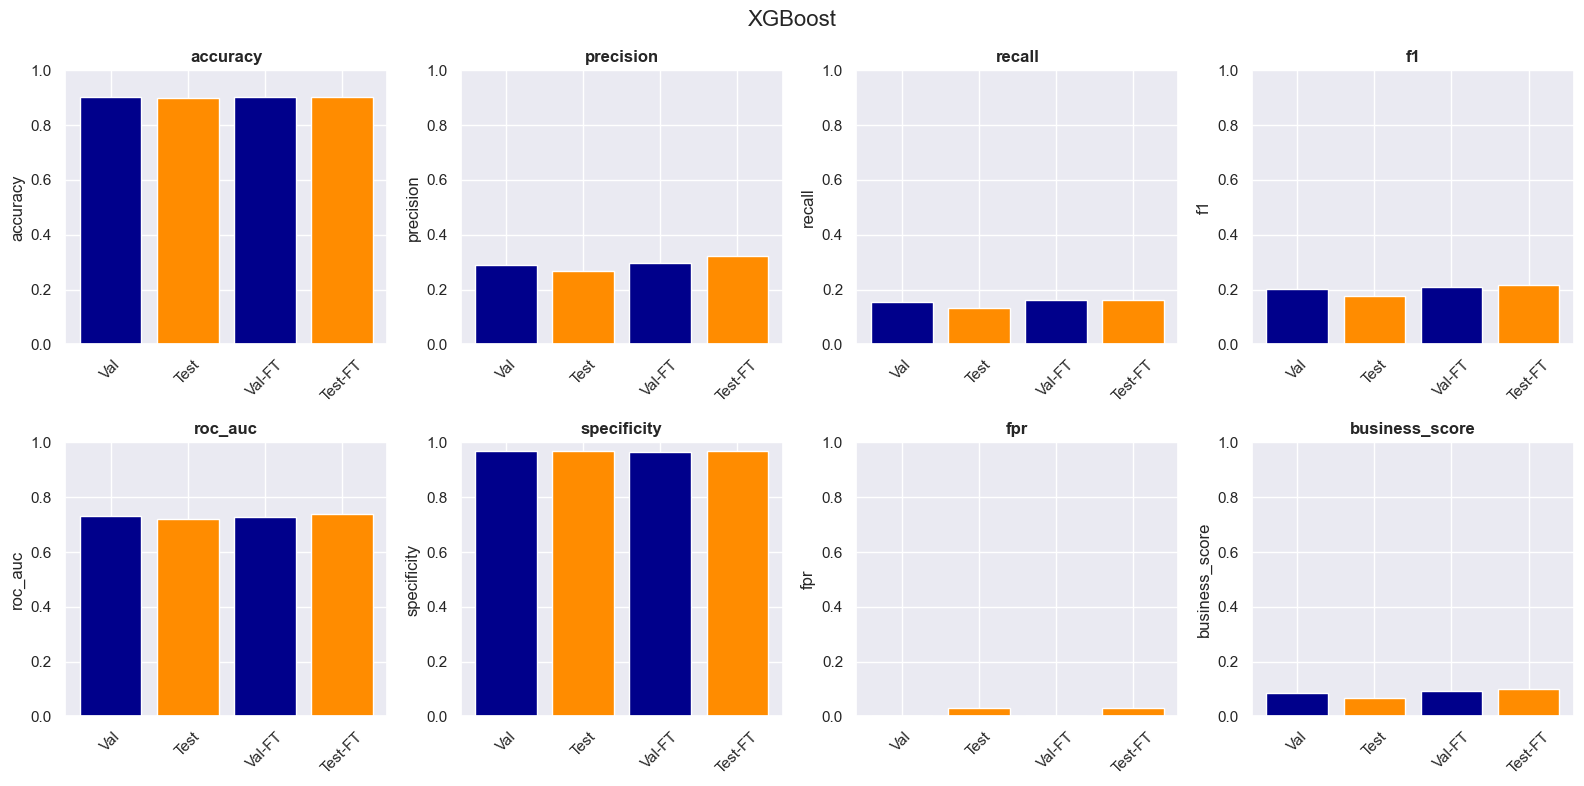

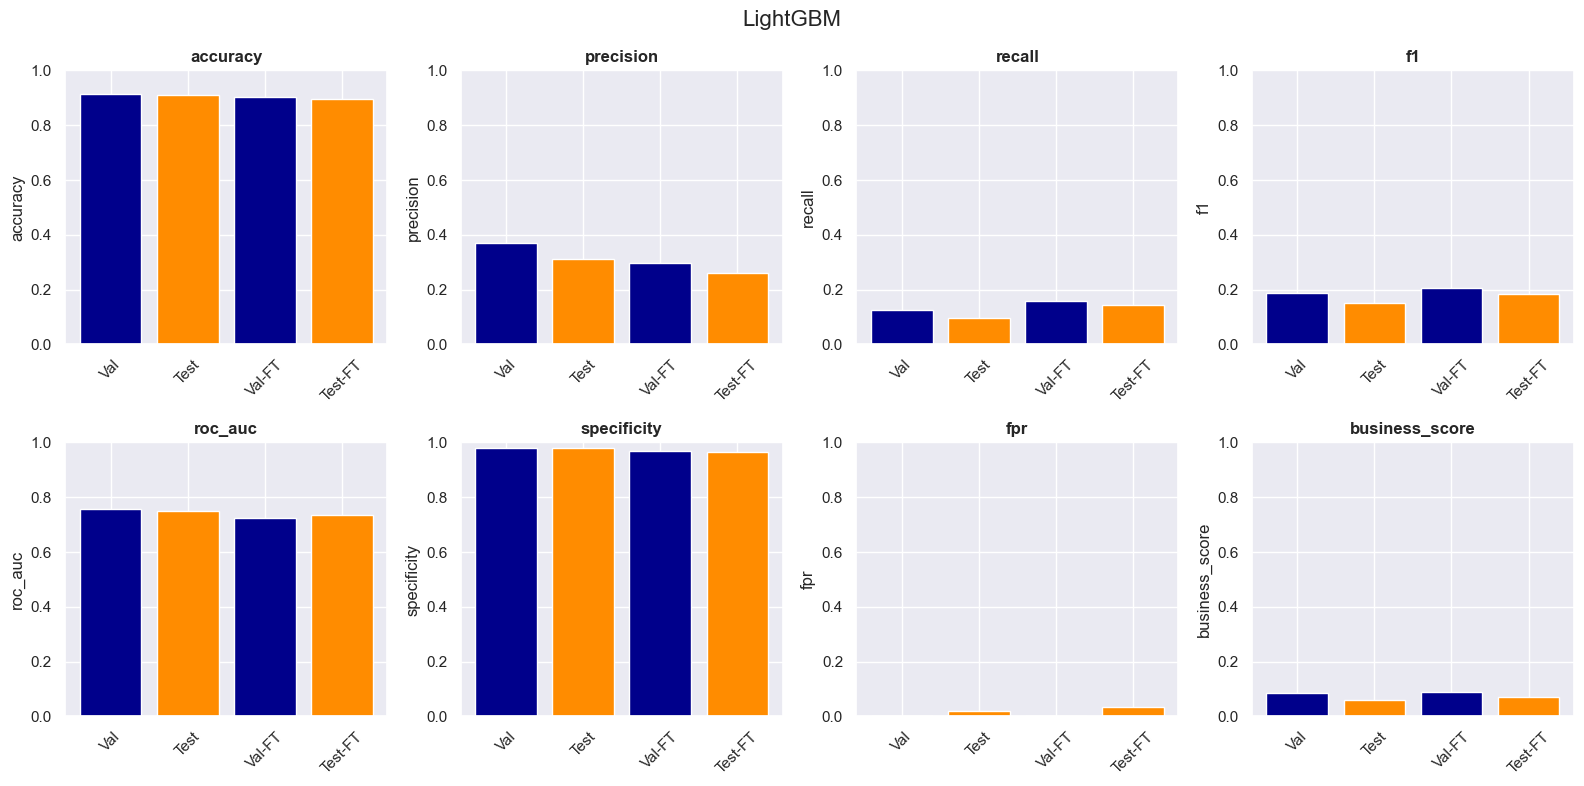

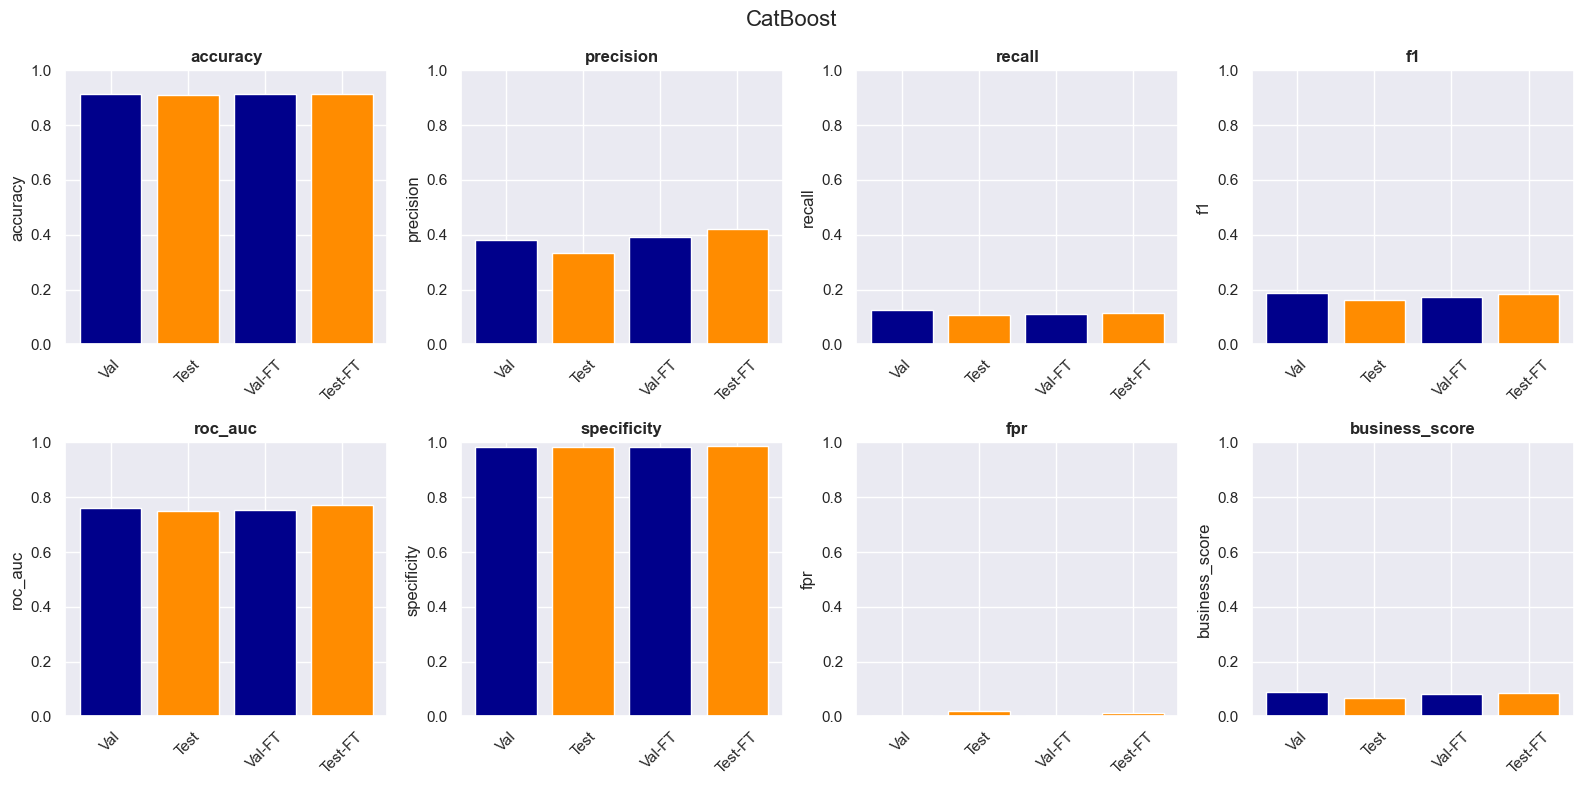

In [96]:
models = {'lr': 'LogisticRegression', 
          'rf': 'RandomForest', 
          'xgbc': 'XGBoost', 
          'lgbmc': 'LightGBM', 
          'cbc': 'CatBoost'}

for model, name in models.items():
    train_results = globals()[model + '_results_cv']
    test_results = globals()[model + '_results_test']
    train_results_ft = globals()[model + 't_results_cv']
    test_results_ft = globals()[model + 't_results_test']
    plot_metrics_dual_per_model(name, train_results, test_results, train_results_ft, test_results_ft)

XGBoost and LightGBM are the best models regarding Business score and Accuracy.
However, **LightGBM** was chosen because it takes a shorter time to train.

In [97]:
# Get best params of LigthGBM and fine tune around them + new hyper parameters

lgbmct_model.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'cpu'}

CPU times: total: 0 ns
Wall time: 1.17 ms
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 18085, number of negative: 18085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101222
[LightGBM] [Info] Number of data points in the train set: 36170, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

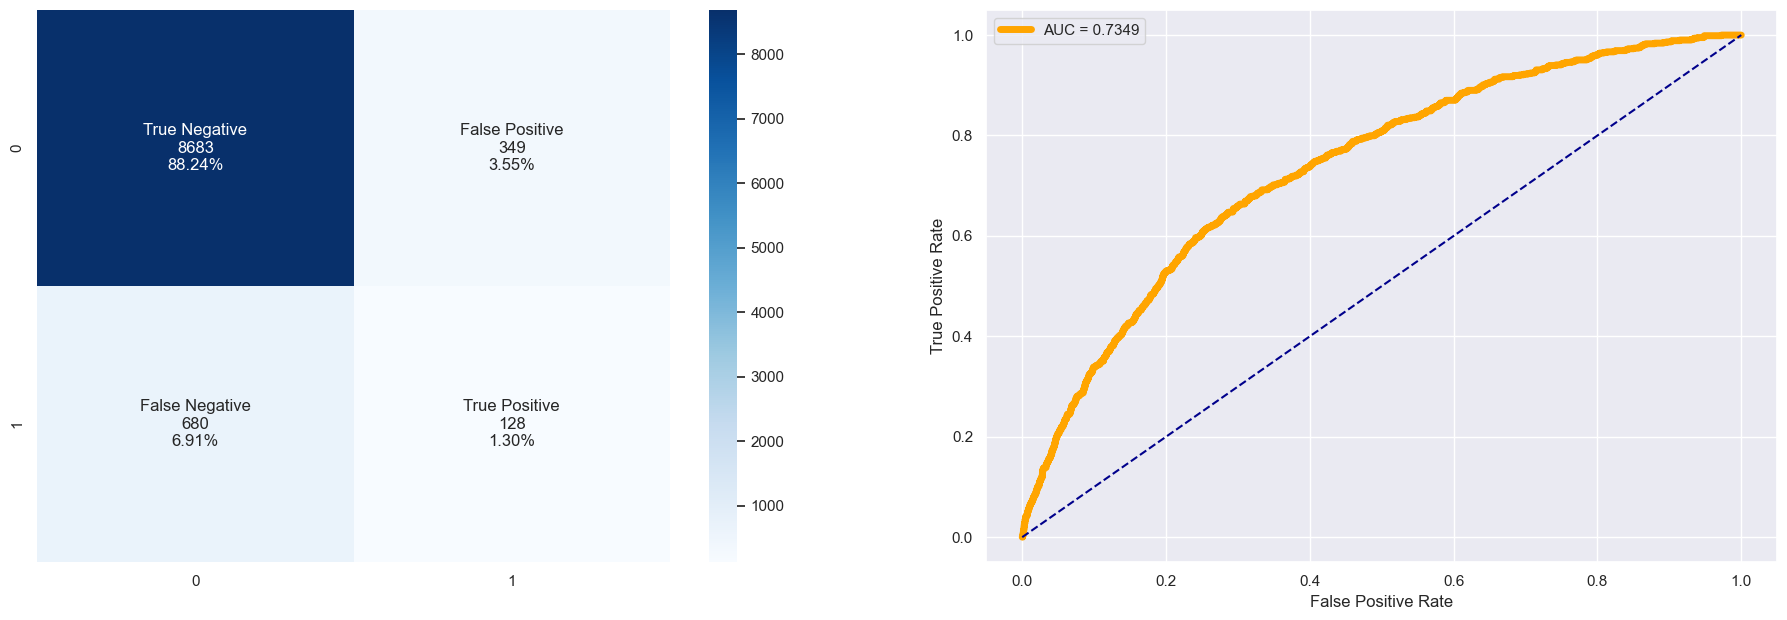

In [105]:
# Fine tune the best model around best params
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned_2'

# Set hyperparameter grid
param_grid = { 
    'classifier__n_estimators': [x for x in range(100, 350, 50)],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__num_leaves': [x for x in range(20, 51, 5)]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2, n_iter=120)

CPU times: total: 0 ns
Wall time: 500 µs
{'fit_time': array([38.45068526, 38.47174382, 37.93507934, 55.12410402, 77.79496098]), 'score_time': array([0.        , 0.        , 0.        , 0.        , 1.66660905]), 'test_accuracy': array([       nan,        nan,        nan,        nan, 0.90599593]), 'test_precision': array([       nan,        nan,        nan,        nan, 0.33161954]), 'test_recall': array([       nan,        nan,        nan,        nan, 0.16246851]), 'test_f1': array([      nan,       nan,       nan,       nan, 0.2180896]), 'test_roc_auc': array([       nan,        nan,        nan,        nan, 0.76119855]), 'test_specificity': array([       nan,        nan,        nan,        nan, 0.97125801]), 'test_fpr': array([        nan,         nan,         nan,         nan, -0.02874199]), 'test_business_score': array([       nan,        nan,        nan,        nan, 0.10293107])}
[LightGBM] [Info] Number of positive: 90461, number of negative: 90461
[LightGBM] [Info] Auto-choosing co

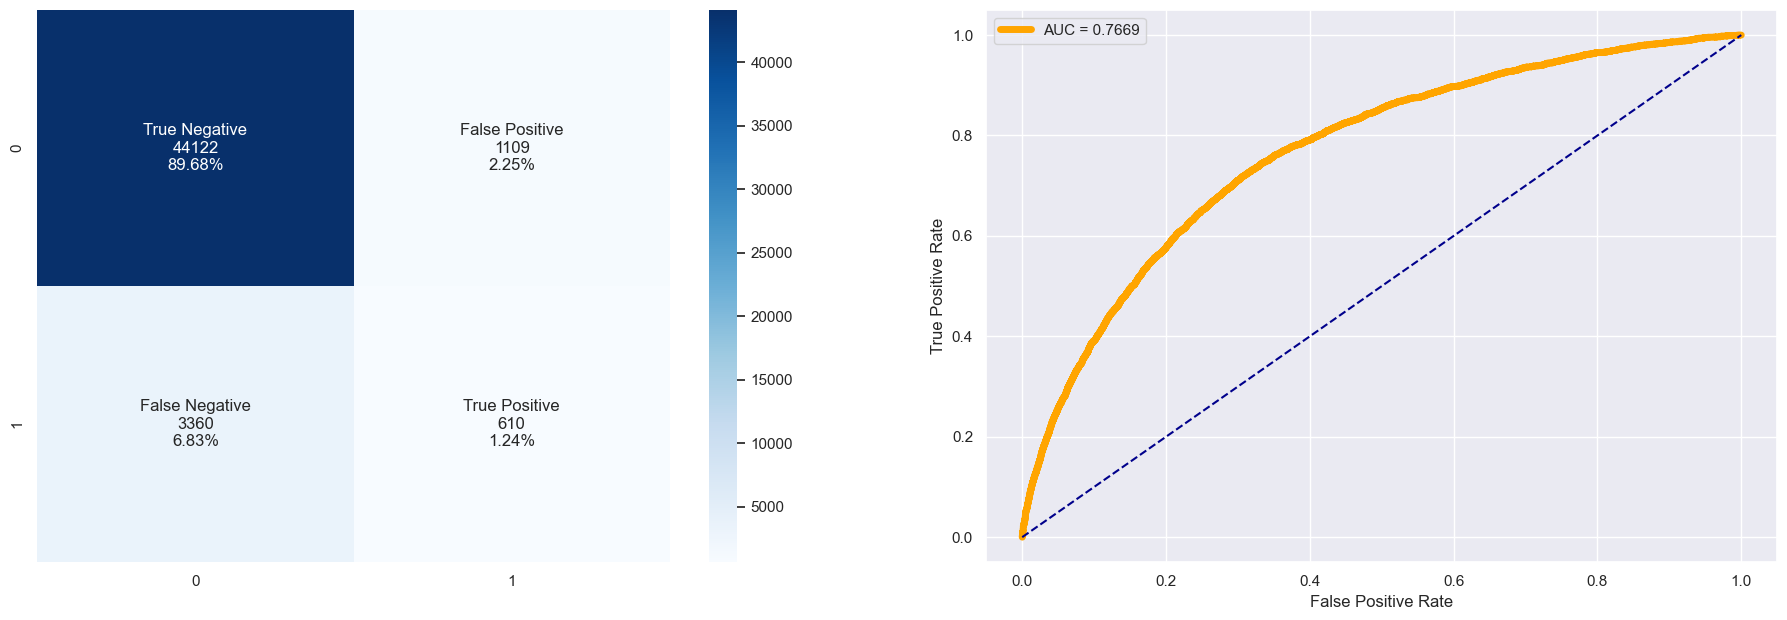

In [113]:
# Train the best model with the whole train dataset
%time
# Get the best params 
best_params = lgbmct_model.named_steps['classifier'].get_params()

# Create LightGBM classifier
lgbmc_final = LGBMClassifier(**best_params)
lgbmc_final_name = 'LightGBM_final'

# Compute results 
lgbmc_final_model, lgbmc_final_results_cv, lgbmc_final_results_test = train_model(lgbmc_final_name, lgbmc_final, cv=5)

In [114]:
lgbmc_final_results_cv

{'accuracy': nan,
 'precision': nan,
 'recall': nan,
 'f1': nan,
 'roc_auc': nan,
 'specificity': nan,
 'fpr': nan,
 'business_score': nan,
 'fit_time': 49.55531468391418,
 'execution_time': 88.24659037590027}

In [115]:
lgbmc_final_results_test

{'fit_time': 39.72686696052551,
 'accuracy': 0.909168512835105,
 'precision': 0.35485747527632344,
 'recall': 0.15365239294710328,
 'f1': 0.21444893654420813,
 'roc_auc': 0.7669297939761451,
 'specificity': 0.975481417611815,
 'fpr': 0.024518582388185096,
 'business_score': 0.10286237691779254}

#### Threshold selection

In [117]:
def threshold_selection(y_test, y_prob):
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype("int")
        score = business_loss_func(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

In [118]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:

        # Compute best threshold
        o_tpr = tpr[np.argmax(tpr - fpr)]
        o_fpr = fpr[np.argmax(tpr - fpr)]
        o_threshold = thresholds[np.argmax(tpr - fpr)]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [119]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [120]:
# Get proba predictions from xgbc model to be class 1 : repay failure
lgbmc_proba = lgbmc_final_model.predict_proba(x_test)[:,1]

Best results
- Best Threshold:	 0.277
- Best Score:		 0.202




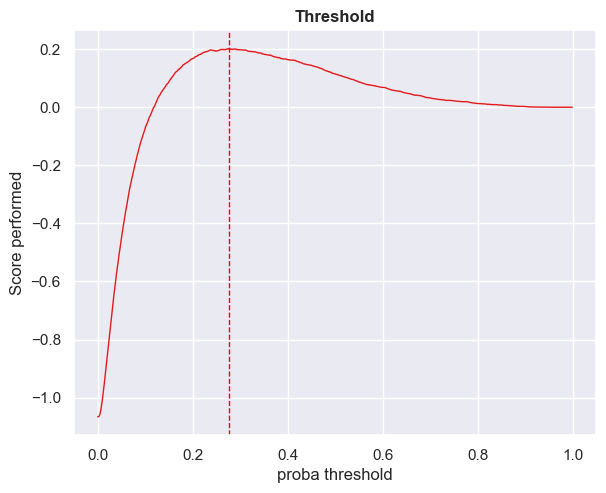

In [121]:
threshold = threshold_selection(y_test, lgbmc_proba)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower. 
Here it gives us 0.293

Let's try different value of the prediction threshold : [0.5, 0.4, 0.3, 0.2, 0.1]

Printing results for threshold = 0.5
Business score = 0.11446322521699406


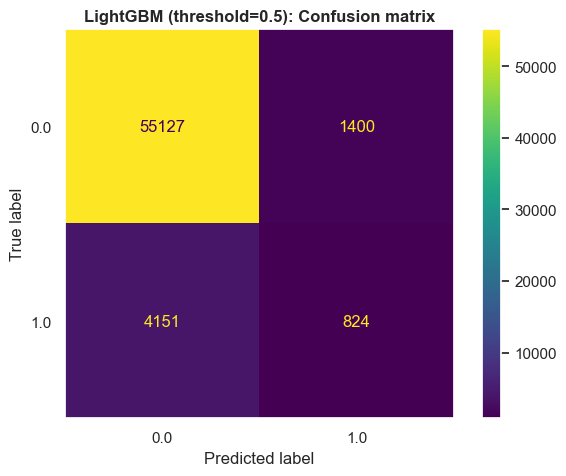

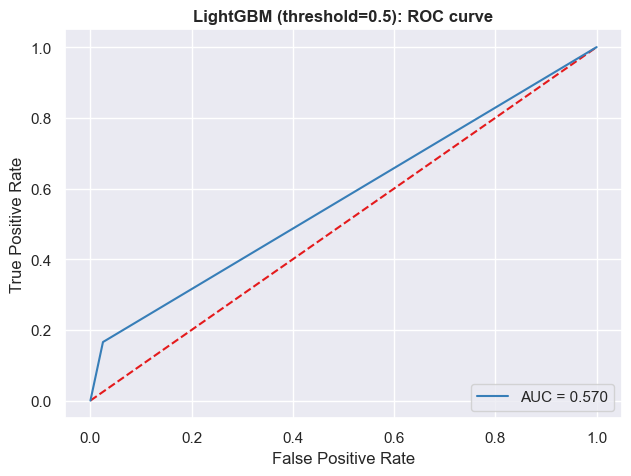

,precision,recall,f1-score,support
0.0,0.929974,0.975233,0.952066,56527.000000
1.0,0.370504,0.165628,0.228921,4975.000000
accuracy,0.909743,0.909743,0.909743,0.909743
macro avg,0.650239,0.570431,0.590493,61502.000000
weighted avg,0.884718,0.909743,0.893570,61502.000000


Printing results for threshold = 0.3
Business score = 0.19771585198720878


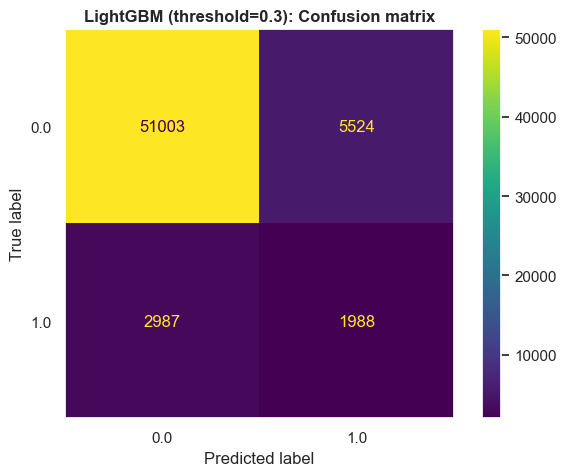

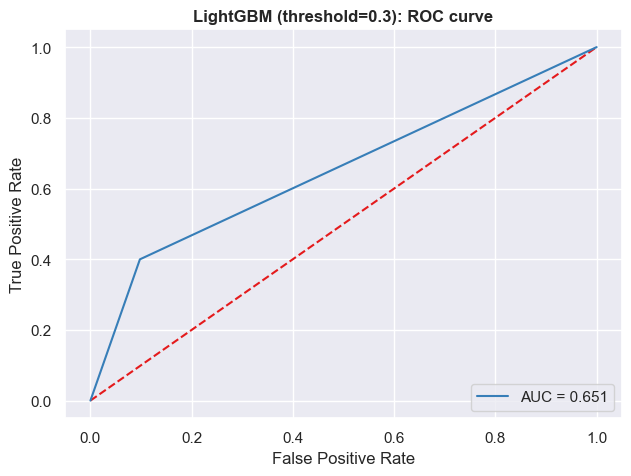

,precision,recall,f1-score,support
0.0,0.944675,0.902277,0.922989,56527.000000
1.0,0.264643,0.399598,0.318411,4975.000000
accuracy,0.861614,0.861614,0.861614,0.861614
macro avg,0.604659,0.650937,0.620700,61502.000000
weighted avg,0.889666,0.861614,0.874084,61502.000000


Printing results for threshold = 0.277
Business score = 0.2019552306989493


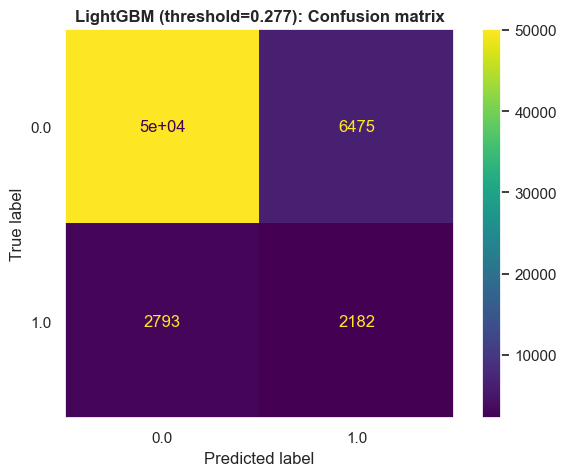

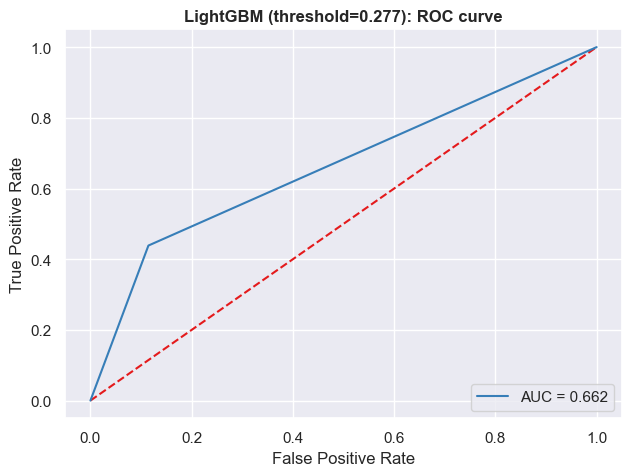

,precision,recall,f1-score,support
0.0,0.947147,0.885453,0.915262,56527.000000
1.0,0.252050,0.438593,0.320129,4975.000000
accuracy,0.849306,0.849306,0.849306,0.849306
macro avg,0.599599,0.662023,0.617695,61502.000000
weighted avg,0.890920,0.849306,0.867120,61502.000000


Printing results for threshold = 0.2
Business score = 0.16730927364093193


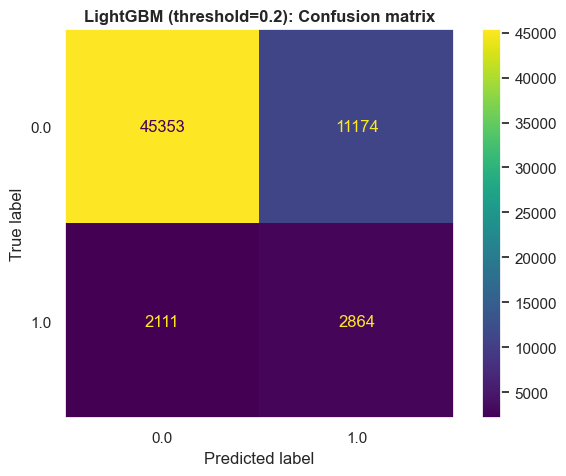

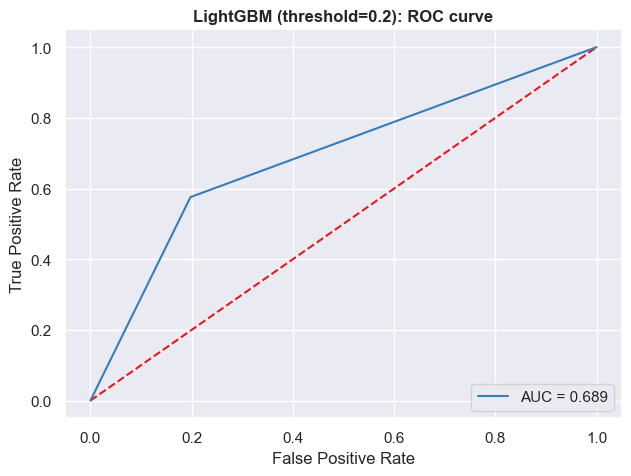

,precision,recall,f1-score,support
0.0,0.955524,0.802325,0.872249,56527.000000
1.0,0.204018,0.575678,0.301268,4975.000000
accuracy,0.783991,0.783991,0.783991,0.783991
macro avg,0.579771,0.689001,0.586758,61502.000000
weighted avg,0.894734,0.783991,0.826061,61502.000000


In [124]:
for threshold in [0.5, 0.3, 0.277, 0.2]: 
    print(f'Printing results for threshold = {threshold}')
    lgbm_pred_std = lgbmc_proba >= threshold
    business_score = business_loss_func(y_test, lgbm_pred_std)
    print('Business score =', business_score)
    display_confusion_matrix(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    auc_score = compute_roc_curve(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    clf_report = pd.DataFrame(classification_report(y_test, lgbm_pred_std, output_dict=True)).transpose()
    display(clf_report)


#### Explainer / Feature importance

##### Global feature importance

In [125]:
feature_importance_df_ = pd.DataFrame({'importance': lgbmc_final_model.steps[2][1].feature_importances_, 
                                       'feature': x_train.columns})

cols = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:20].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

AttributeError: 'LGBMClassifier' object has no attribute 'steps'